In [2]:
# from google.colab import files
# uploaded = files.upload()

import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

print("Path to dataset files:", path)
uploaded=pd.read_csv("../kaggle/input/breast-cancer-dataset/breast-cancer.csv")

Path to dataset files: /kaggle/input/breast-cancer-dataset


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split , StratifiedKFold, GridSearchCV,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import shap

In [4]:
df = uploaded
df.head()
df = df.drop(columns=['id'])
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
df.isnull().sum() ##no missing values

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Text(0.5, 1.0, 'Correlation Matrix Heatmap with Target Variable')

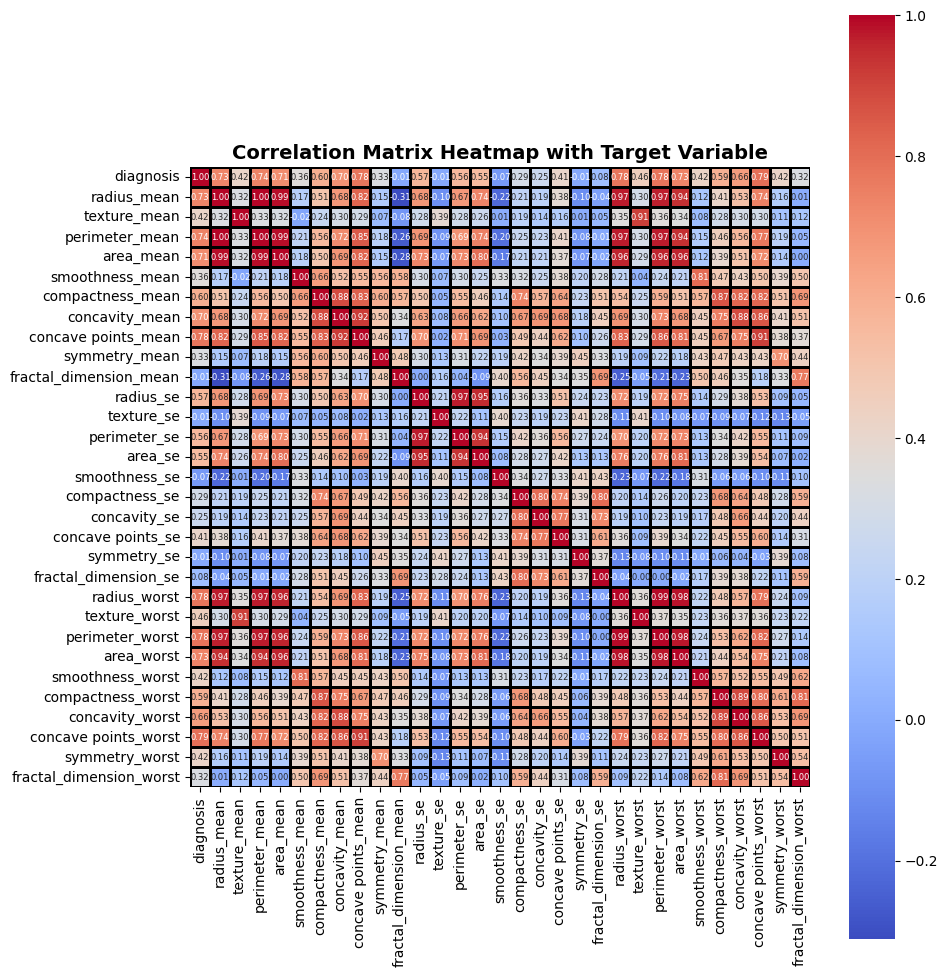

In [8]:
plt.figure(figsize=(10, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f",linewidths=1,
            linecolor='black', annot_kws={"size": 6}, cbar=True, square=True)
plt.title("Correlation Matrix Heatmap with Target Variable", fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Correlation Matrix Heatmap Without Target Variable')

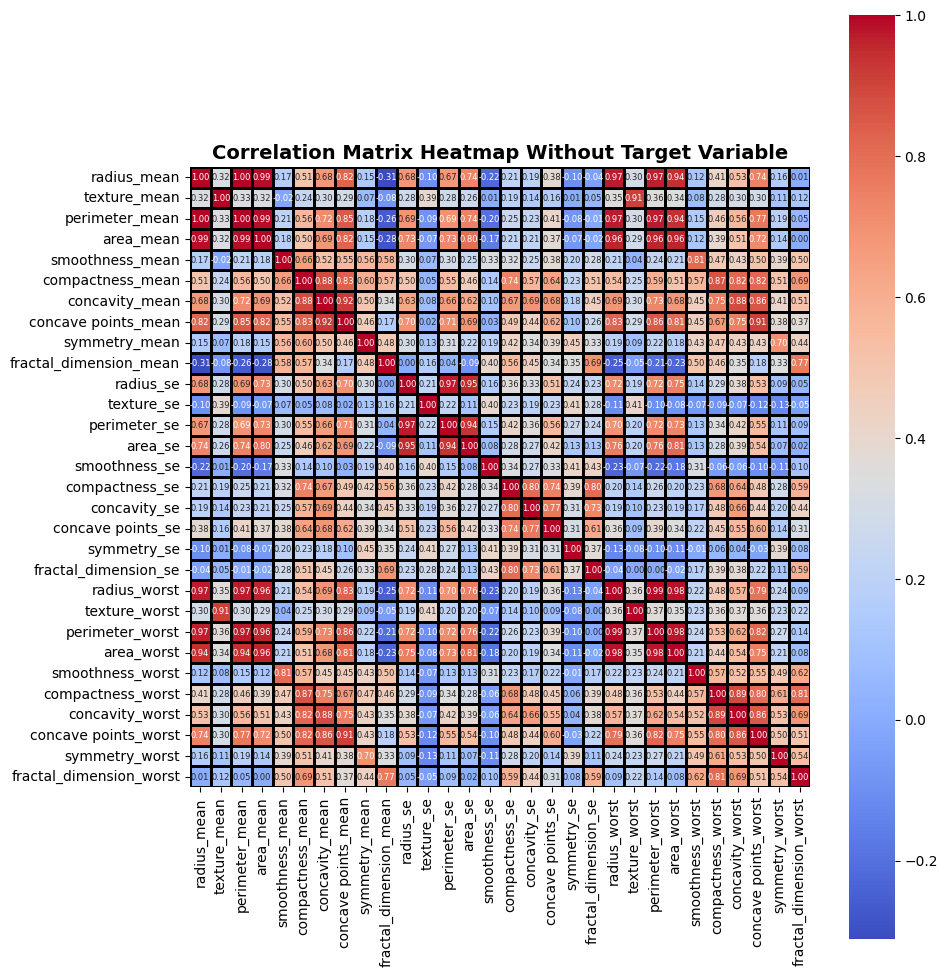

In [9]:
plt.figure(figsize=(10, 12))
sns.heatmap(df.drop(columns= ['diagnosis']).corr(), annot=True, cmap='coolwarm', fmt=".2f",linewidths=1,
            linecolor='black', annot_kws={"size": 6}, cbar=True, square=True)
plt.title("Correlation Matrix Heatmap Without Target Variable", fontsize=14, fontweight='bold')

In [5]:
corr_values = abs(df.corr()["diagnosis"])
corr_values

diagnosis                  1.000000
radius_mean                0.730029
texture_mean               0.415185
perimeter_mean             0.742636
area_mean                  0.708984
smoothness_mean            0.358560
compactness_mean           0.596534
concavity_mean             0.696360
concave points_mean        0.776614
symmetry_mean              0.330499
fractal_dimension_mean     0.012838
radius_se                  0.567134
texture_se                 0.008303
perimeter_se               0.556141
area_se                    0.548236
smoothness_se              0.067016
compactness_se             0.292999
concavity_se               0.253730
concave points_se          0.408042
symmetry_se                0.006522
fractal_dimension_se       0.077972
radius_worst               0.776454
texture_worst              0.456903
perimeter_worst            0.782914
area_worst                 0.733825
smoothness_worst           0.421465
compactness_worst          0.590998
concavity_worst            0.659610
concave points_worst       0.793566
symmetry_worst             0.416294
fractal_dimension_worst    0.323872
Name: diagnosis, dtype: float64

In [6]:
relevant_features = corr_values[corr_values>0.4]
relevant_features = list(relevant_features.index)
relevant_features

['diagnosis',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'concave points_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst']

In [7]:
if 'diagnosis' in relevant_features:
    relevant_features.remove('diagnosis')
else:
    print("'diagnosis' not found in features. Check your data or threshold.")

In [10]:
rel = df[['diagnosis'] + relevant_features]

Text(0.5, 1.0, 'Reduced Correlation Matrix Heatmap With Target Variable')

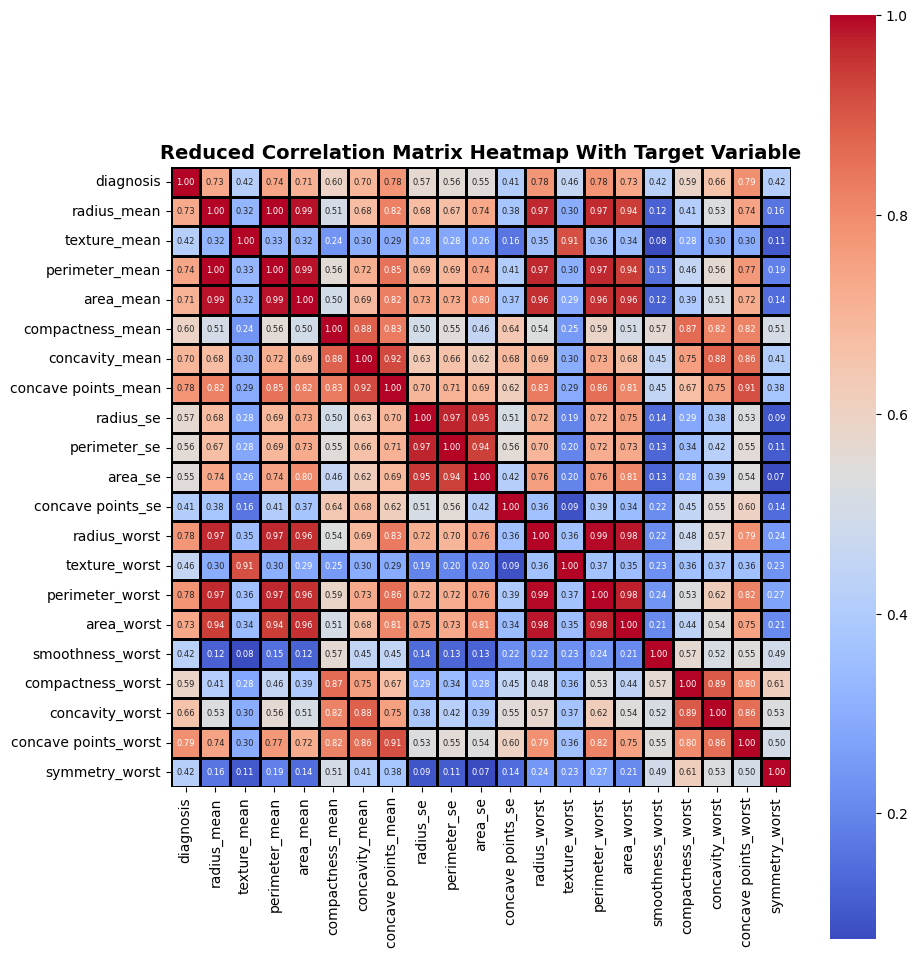

In [11]:
plt.figure(figsize=(10, 12))
sns.heatmap(rel.corr(), annot=True, cmap='coolwarm', fmt=".2f",linewidths=1,
            linecolor='black', annot_kws={"size": 6}, cbar=True, square=True)
plt.title("Reduced Correlation Matrix Heatmap With Target Variable", fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Reduced Correlation Matrix Heatmap Without Target Variable')

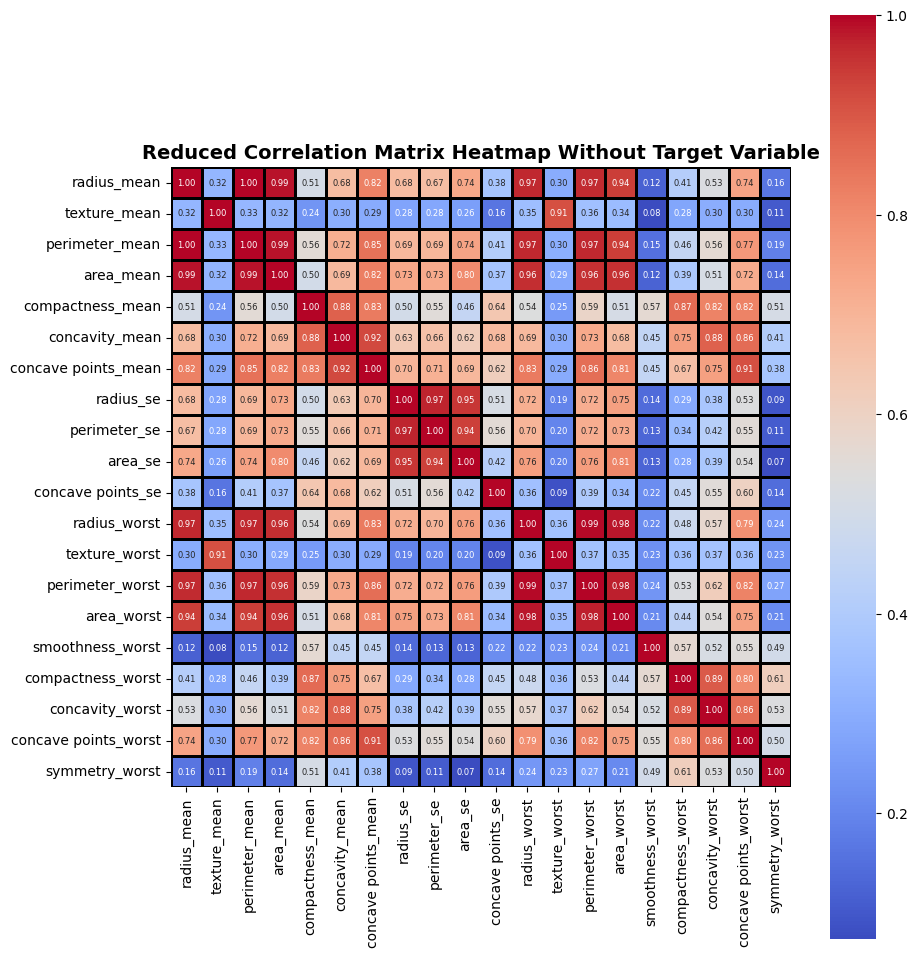

In [ ]:
plt.figure(figsize=(10, 12))
sns.heatmap(rel.drop(columns= ['diagnosis']).corr(), annot=True, cmap='coolwarm', fmt=".2f",linewidths=1,
            linecolor='black', annot_kws={"size": 6}, cbar=True, square=True)
plt.title("Reduced Correlation Matrix Heatmap Without Target Variable", fontsize=14, fontweight='bold')

In [12]:
if 'diagnosis' in relevant_features:
    relevant_features.remove('diagnosis')
else:
    print("'diagnosis' not found in features. Check your data or threshold.")

# Create X and y
X = df[relevant_features]
y = df['diagnosis'].values

'diagnosis' not found in features. Check your data or threshold.


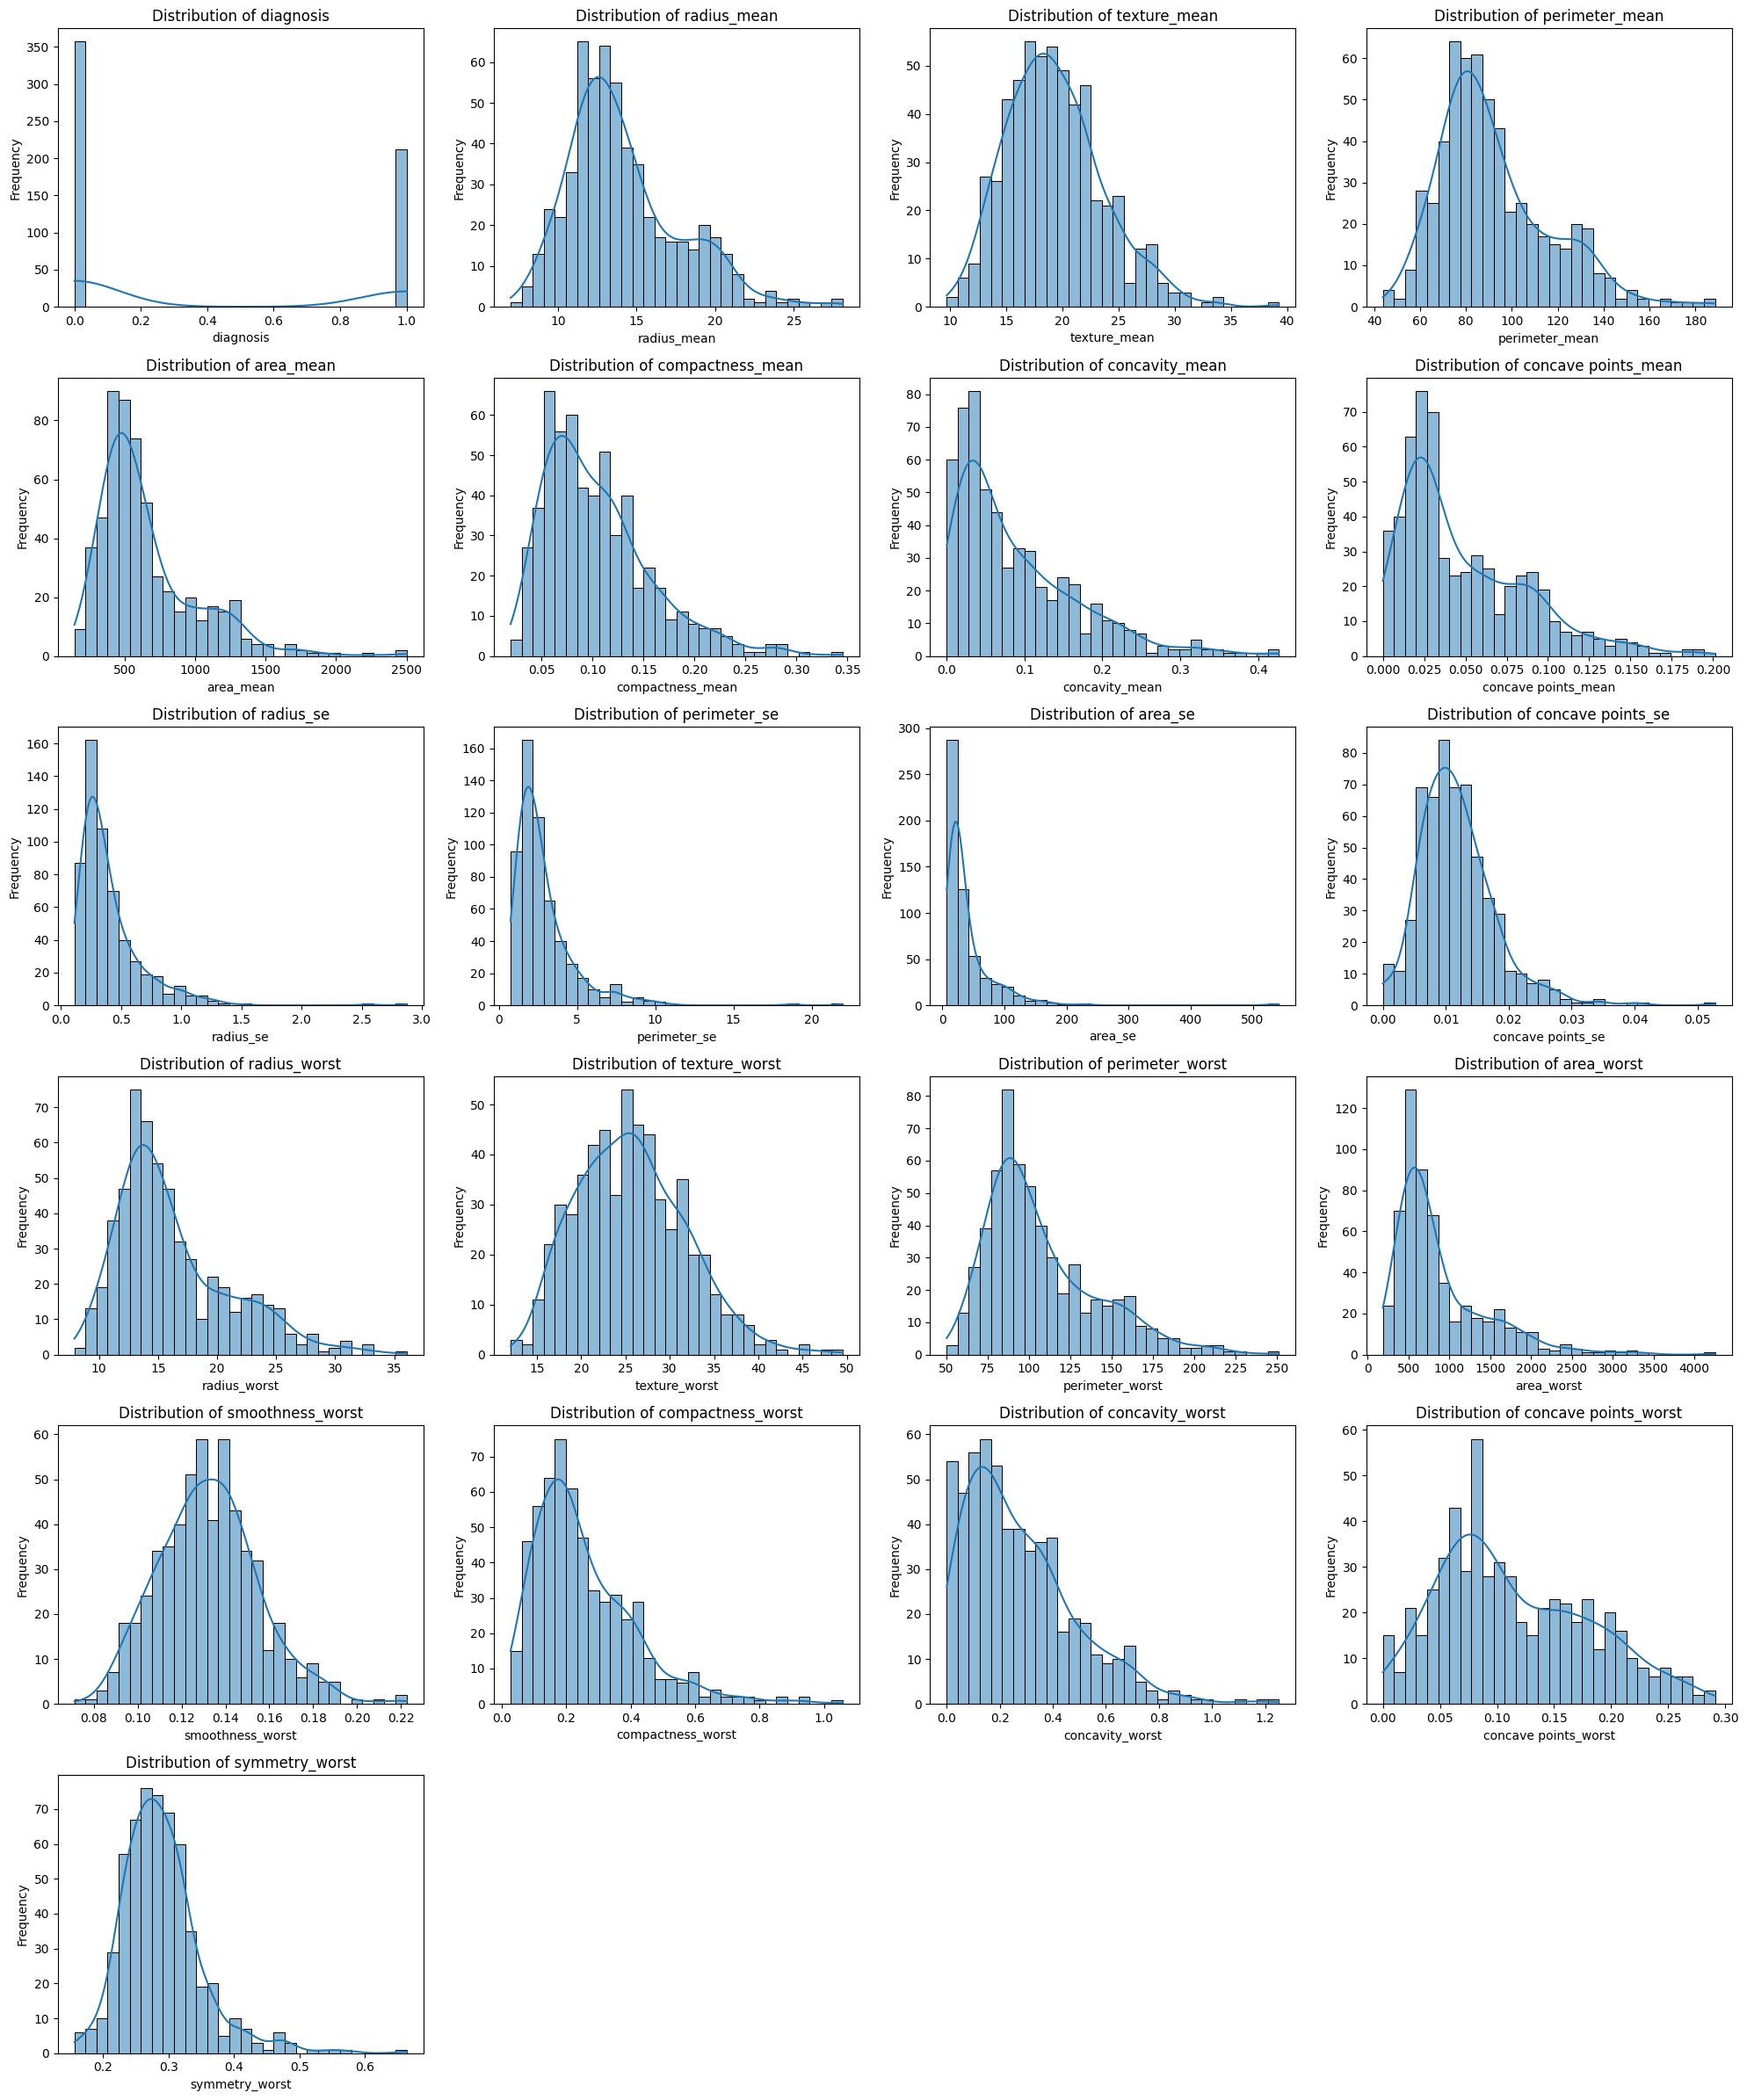

In [ ]:
numeric_cols = rel.select_dtypes(include='number').columns
n_cols = len(numeric_cols)

# Define grid size (e.g., 3x3, 4x4 based on number of features)
cols = 4  # Number of plots per row
rows = int(np.ceil(n_cols / cols))  # Number of rows needed

# Set up the overall figure
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten to easily index

# Plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(rel[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Distribution of Features.jpeg")
plt.show()

<ipython-input-19-473cbcd15fd3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=rel, palette={'0': 'salmon', '1': 'skyblue'})


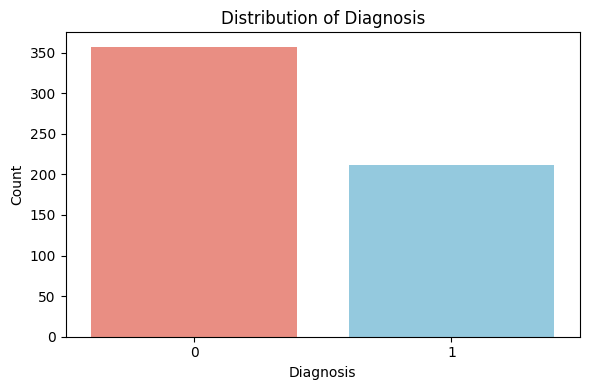

In [ ]:
##Distribution of Diagnosis Column
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=rel, palette={'0': 'salmon', '1': 'skyblue'})
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
##357 0 (benign) and 212 1 (malignant)

In [13]:
##Train Test Split
X = rel.iloc[:,1:]
y = rel.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=14)

#Standardize data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

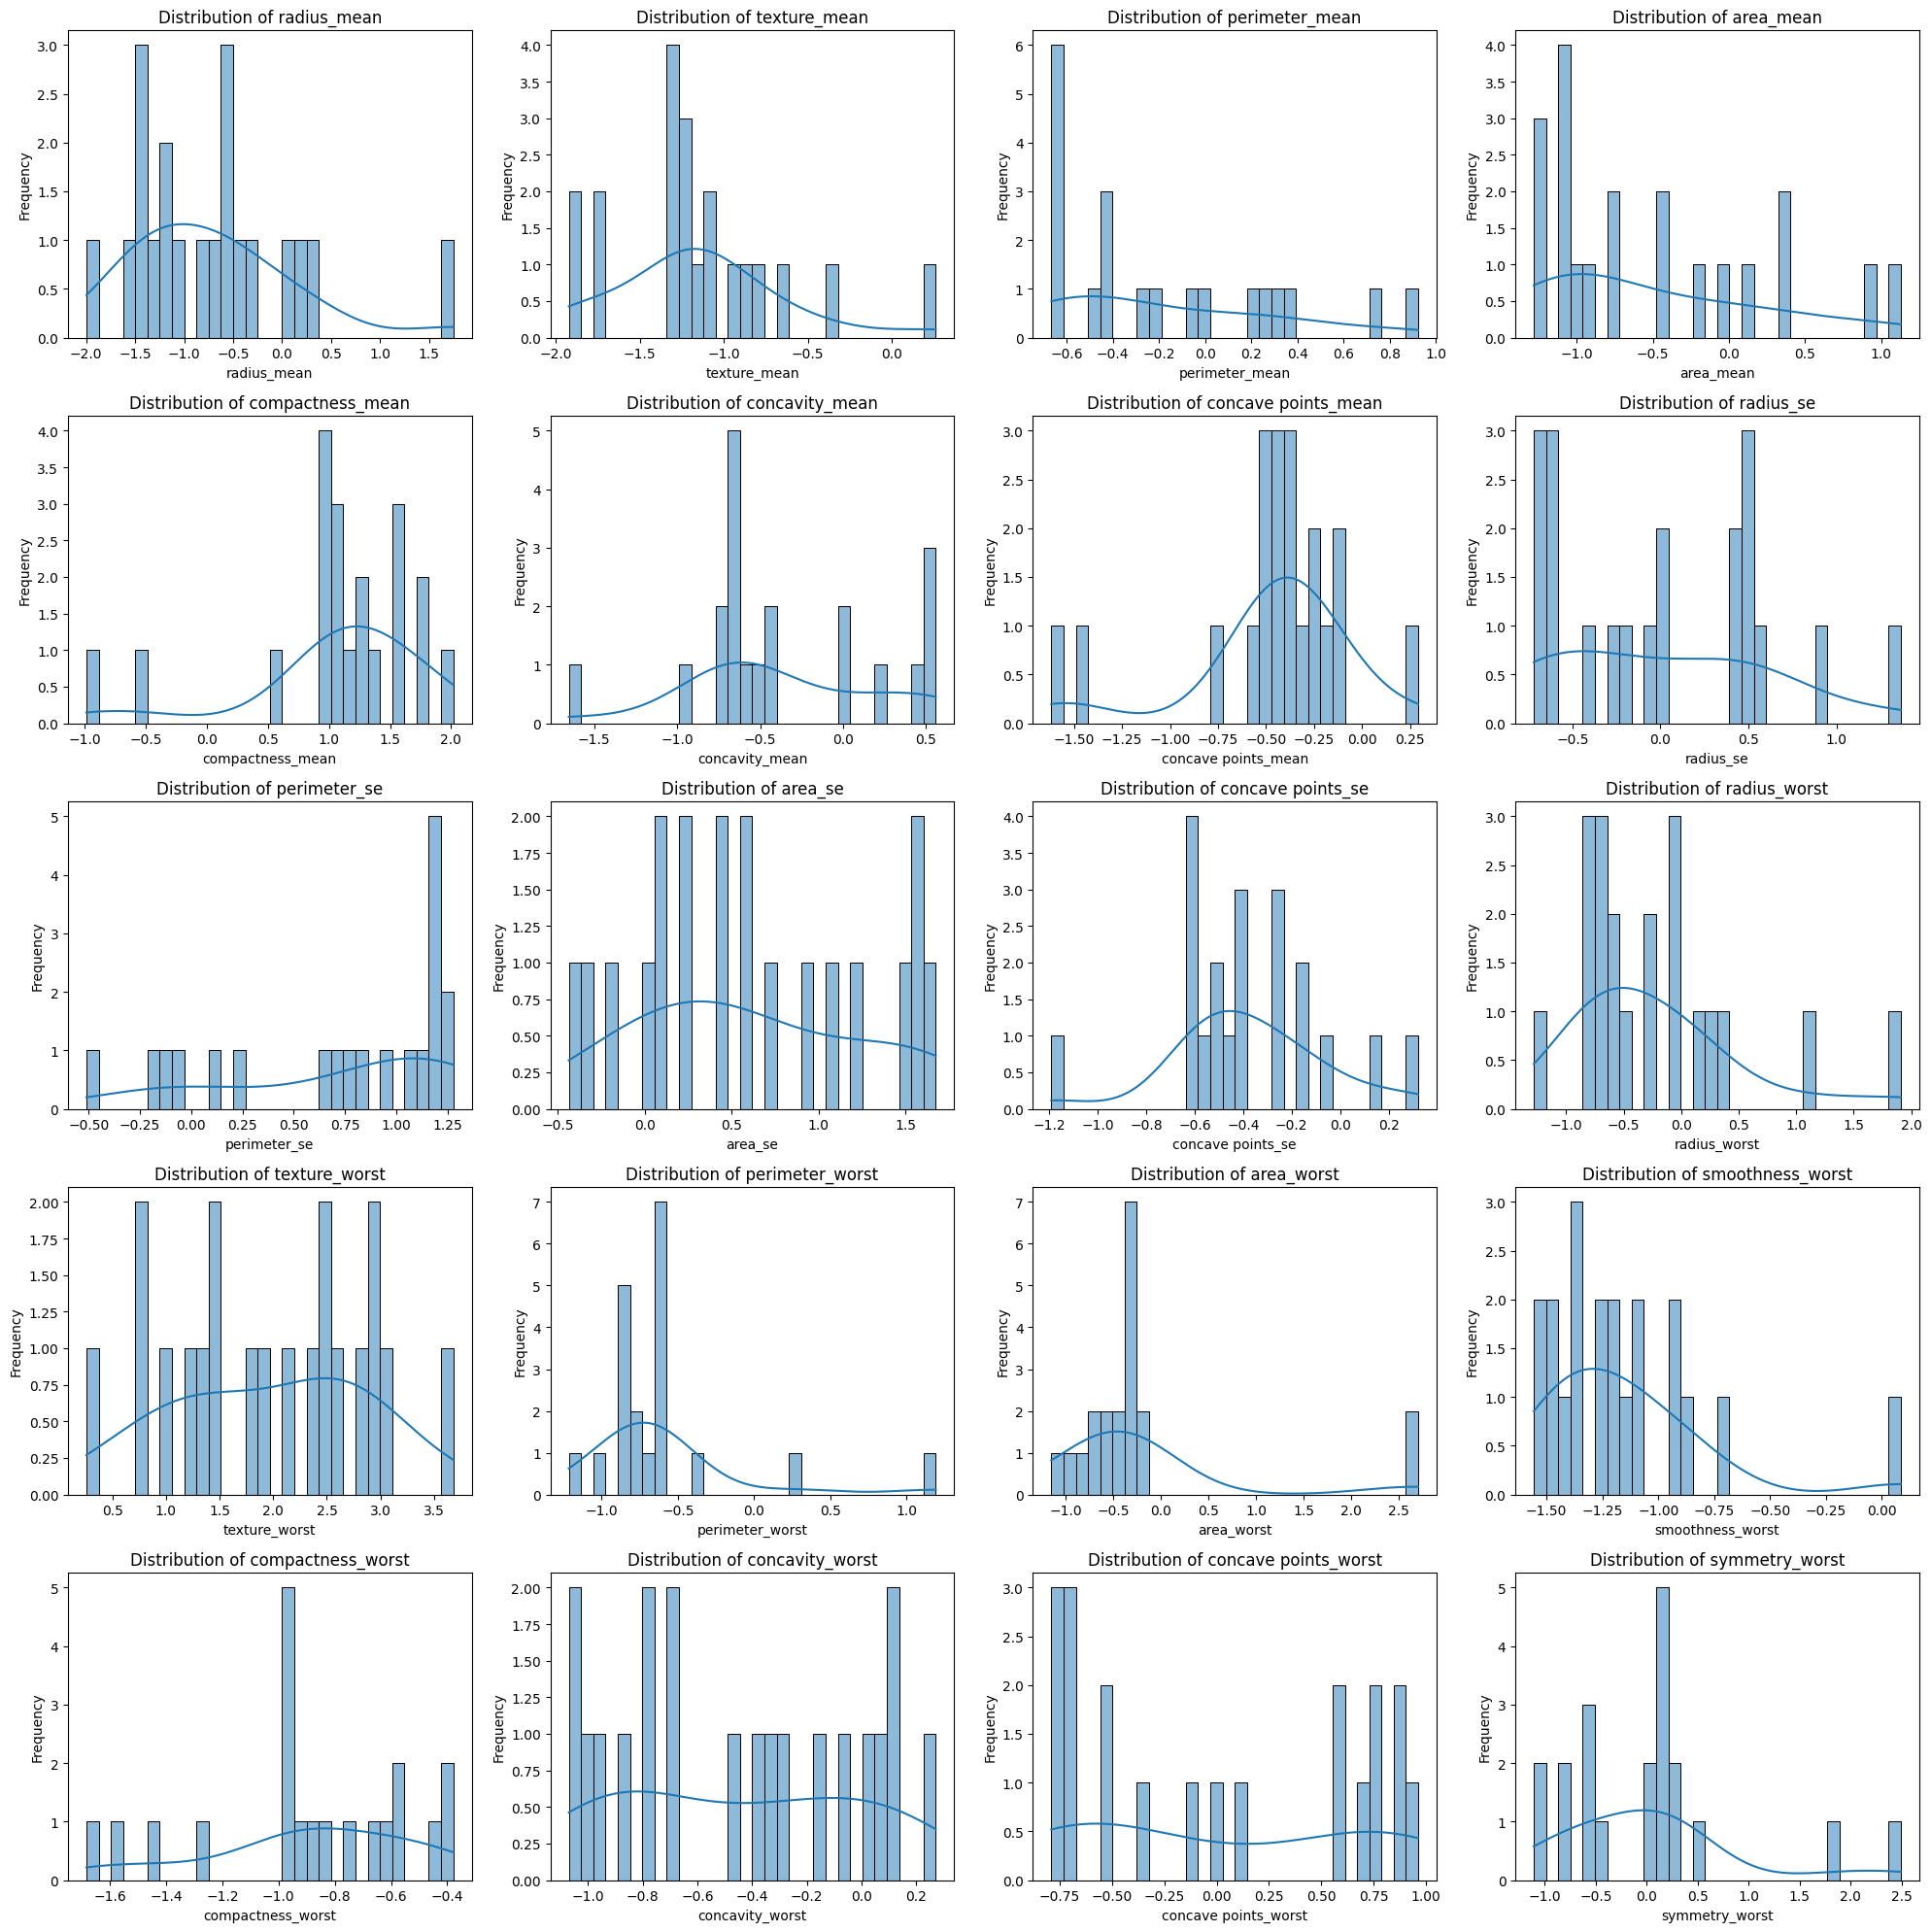

In [ ]:
# Same as above but modified to exclude target, which isn't available in X
# Define grid size (e.g., 3x3, 4x4 based on number of features)
cols = 4  # Number of plots per row
rows = int(np.ceil((n_cols-1) / cols))  # Number of rows needed

# Set up the overall figure
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Flatten to easily index

# Plot each histogram
for i, col in enumerate(numeric_cols):
    if i==0:
      continue
    sns.histplot(X_train_std[i-1], kde=True, bins=30, ax=axes[i-1])
    axes[i-1].set_title(f'Distribution of {col}')
    axes[i-1].set_xlabel(col)
    axes[i-1].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Distribution of Scaled Features.jpeg")
plt.show()

In [ ]:
##Decision Tree Classifier - no change in hyperparameters
clf=DecisionTreeClassifier()
clf.fit(X_train_std,y_train)
y_pred_train = clf.predict(X_train_std)
y_pred_std=clf.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"Test Accuracy: {accuracy_score(y_test,y_pred_std)}")

Train Accuracy: 1.0
Test Accuracy: 0.956140350877193


In [ ]:
# Compute precision-recall pairs
precision1, recall1, _ = precision_recall_curve(y_test, y_pred_std)
avg_precision1 = average_precision_score(y_test, y_pred_std)
print(precision1)
print(recall1)

[0.35964912 0.95       1.        ]
[1.         0.92682927 0.        ]


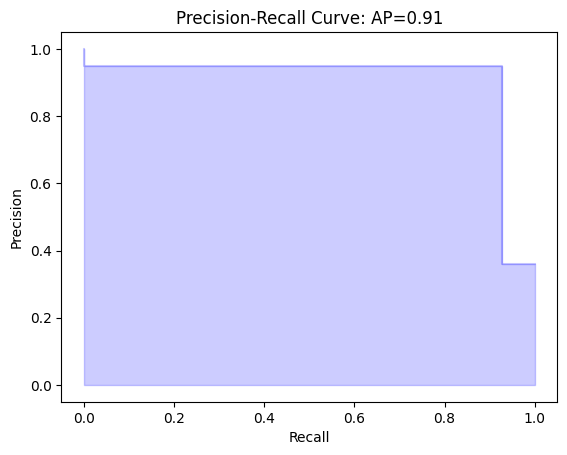

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall1, precision1, color='b', alpha=0.2, where='post')
plt.fill_between(recall1, precision1, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision1))
plt.show()

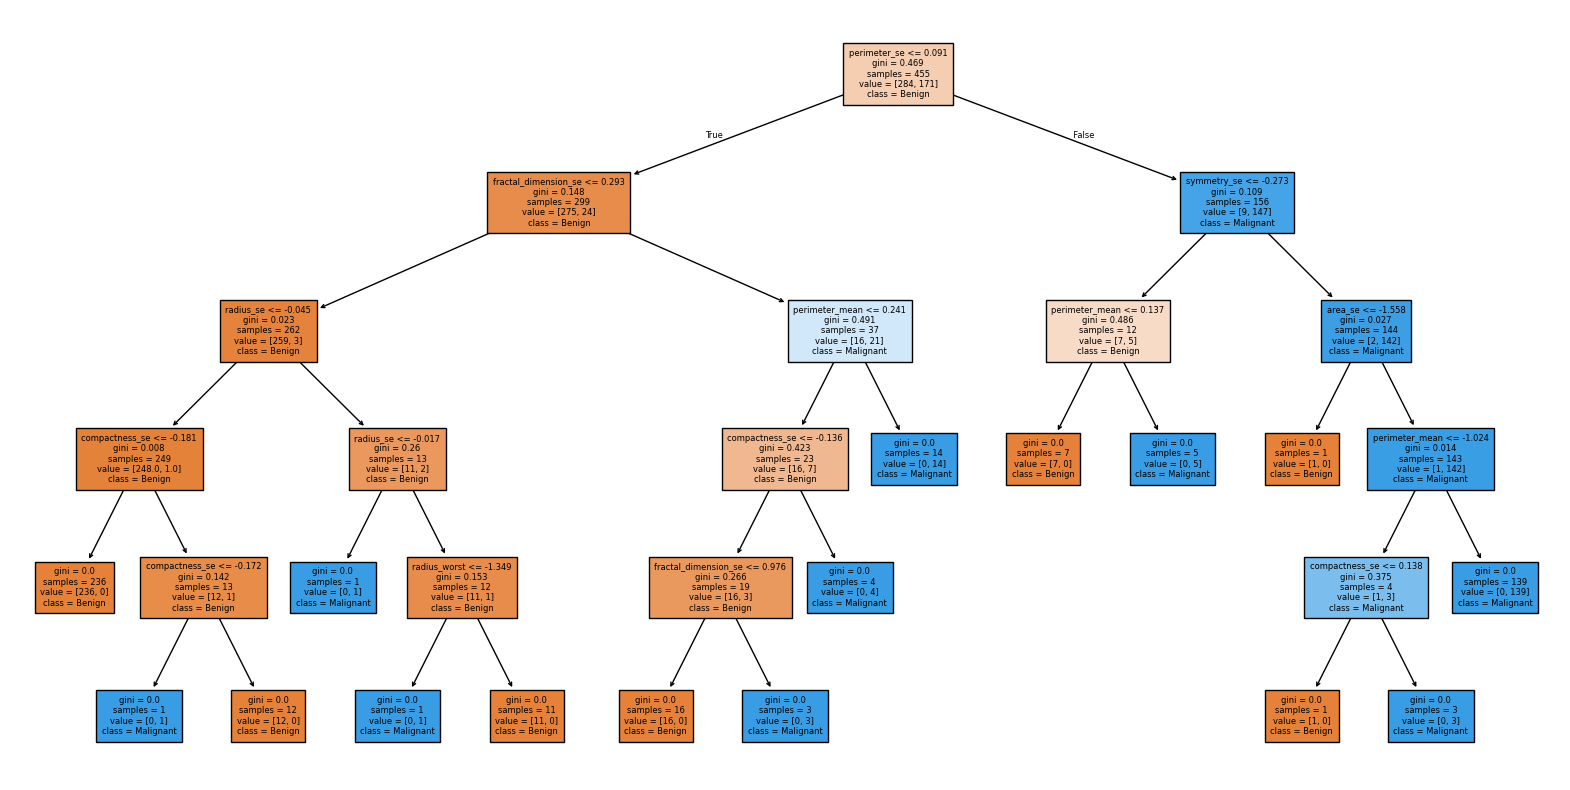

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(clf,filled=True,feature_names=df.columns[2:],class_names = ['Benign', 'Malignant'], fontsize = 6)
plt.savefig("Dec_Tree.png")
plt.show()

In [ ]:
y_pred_std_probs = clf.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_probs)}")

AUC: 0.9497160040093551


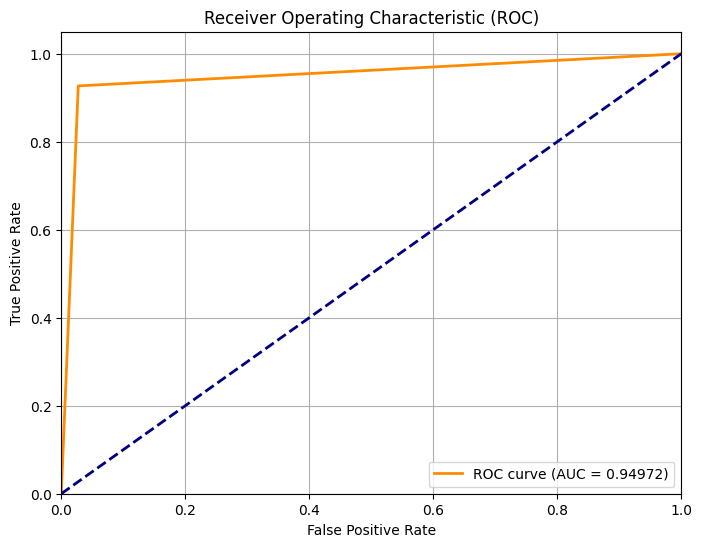

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_std_probs)
roc_auc1 = auc(fpr1, tpr1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc1:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
##Randomized Search with Cross-Validation
dt = DecisionTreeClassifier()
param_grid_dt= {'criterion': ['gini', 'entropy'], 'max_depth': [None]+list(range(1,81)),
    'min_samples_split': range(2,51), 'random_state': range(1,101), 'class_weight': [None, 'balanced']}
dtr = RandomizedSearchCV(estimator = dt, param_distributions = param_grid_dt, cv = 5, n_jobs = -1, random_state = 42, return_train_score = True)
dtr_result = dtr.fit(X_train_std, y_train)
print("Best: %f using %s" % (dtr_result.best_score_, dtr_result.best_params_))
print(dtr.best_estimator_.score(X_test_std, y_test))

Best: 0.934066 using {'random_state': 38, 'min_samples_split': 3, 'max_depth': 28, 'criterion': 'gini', 'class_weight': None}
0.9649122807017544


In [ ]:
#Create new Decision tree classifier with new parameters
dtree = DecisionTreeClassifier(random_state = 38, min_samples_split = 3, max_depth = 28, criterion = 'gini', class_weight = None)
dtree.fit(X_train_std, y_train)
y_pred_train_tuned = dtree.predict(X_train_std)
y_pred_std_tuned = dtree.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_tuned)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_std_tuned)}")

Train Accuracy: 1.0
Test Accuracy: 0.9649122807017544


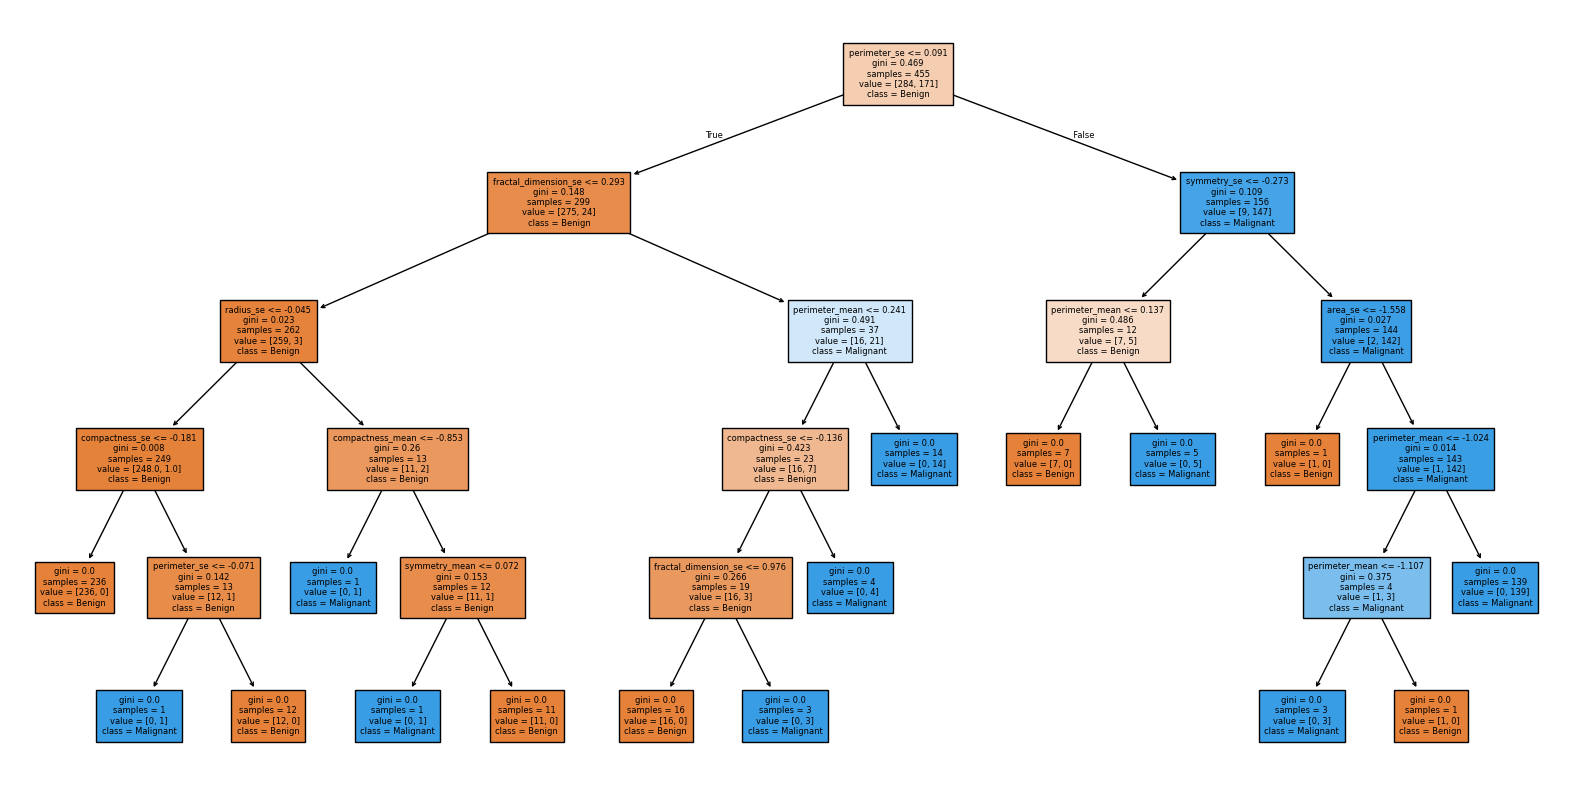

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dtree, filled=True, feature_names=df.columns[2:], class_names = ['Benign', 'Malignant'], fontsize = 6)
plt.savefig("Dec_Tree_Tuned.png")
plt.show()

In [ ]:
# Compute precision-recall pairs
precision2, recall2, _ = precision_recall_curve(y_test, y_pred_std_tuned)
avg_precision2 = average_precision_score(y_test, y_pred_std_tuned)
print(precision2)
print(recall2)

[0.35964912 0.97435897 1.        ]
[1.         0.92682927 0.        ]


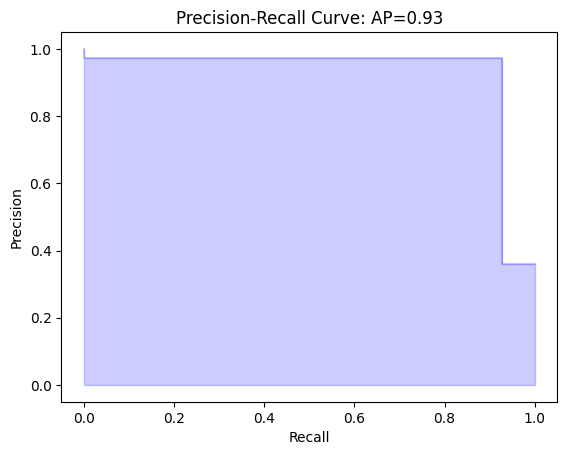

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall2, precision2, color='b', alpha=0.2, where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision2))
plt.show()

In [ ]:
y_pred_std_tuned_probs = dtree.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_tuned_probs)}")

AUC: 0.9565653190778483


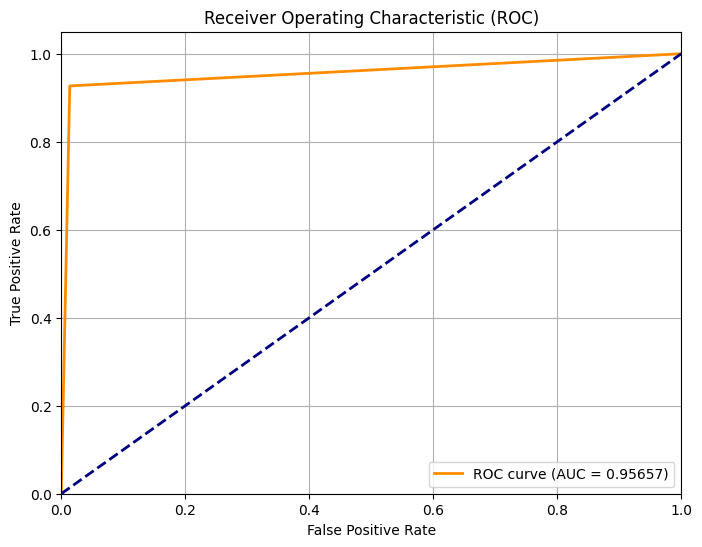

In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_std_tuned_probs)
roc_auc2 = auc(fpr2, tpr2)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc2:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

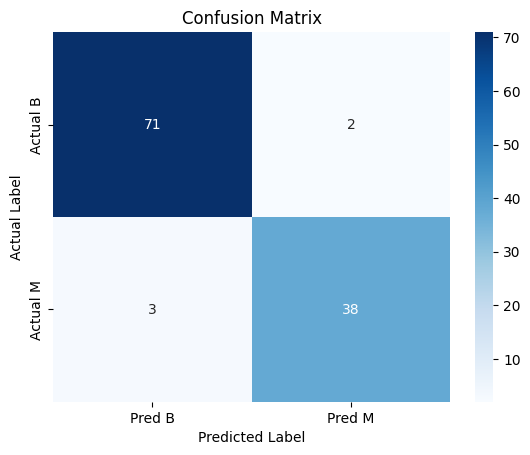

In [ ]:
cm1 = confusion_matrix(y_test, y_pred_std)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

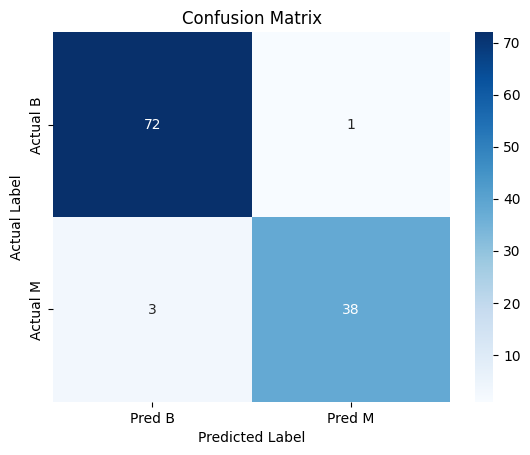

In [ ]:
#Confusion Matrix
cm2 = confusion_matrix(y_test, y_pred_std_tuned)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
TN, FP, FN, TP = cm1.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.950
Recall: 0.927
F1-Score: 0.94


In [ ]:
TN, FP, FN, TP = cm2.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.974
Recall: 0.927
F1-Score: 0.95


In [ ]:
#Shap
# Fits the explainer
explainer = shap.Explainer(dtree.predict, X_test_std)
shap_values = explainer(X_test_std)

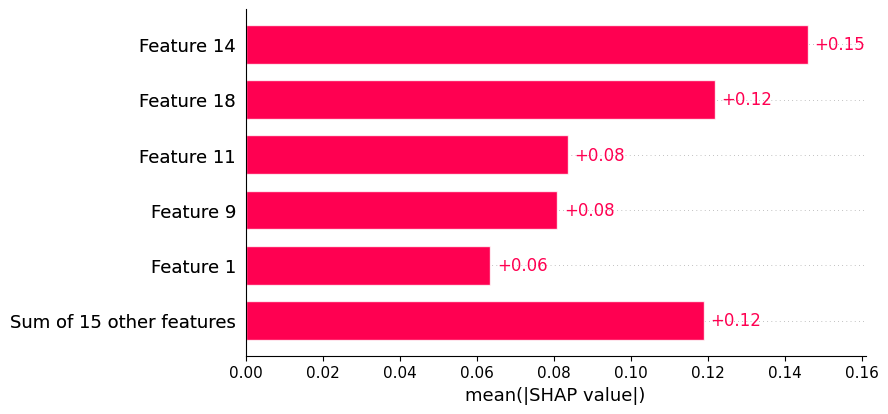

In [ ]:
shap.plots.bar(shap_values, max_display = 6)

In [ ]:
X.columns[[14, 18, 9, 11, 1]]

Index(['area_worst', 'concave points_worst', 'area_se', 'radius_worst',
       'texture_mean'],
      dtype='object')

In [ ]:
##Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
y_pred_train_lr = lr.predict(X_train_std)
y_pred_std_lr = lr.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train,y_pred_train_lr)}")
print(f"Test Accuracy: {accuracy_score(y_test,y_pred_std_lr)}")

Train Accuracy: 0.9868131868131869
Test Accuracy: 0.9824561403508771


In [ ]:
# Compute precision-recall pairs
precision3, recall3, _ = precision_recall_curve(y_test, y_pred_std_lr)

# Compute the area under the precision-recall curve
avg_precision3 = average_precision_score(y_test, y_pred_std_lr)

print(precision3)
print(recall3)

[0.35964912 1.         1.        ]
[1.         0.95121951 0.        ]


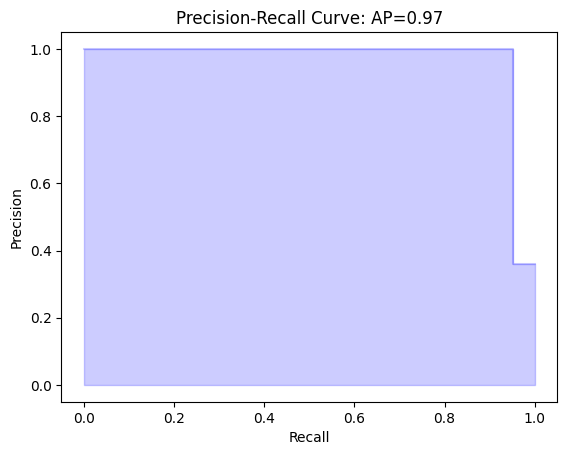

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall3, precision3, color='b', alpha=0.2, where='post')
plt.fill_between(recall3, precision3, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision3))
plt.show()

In [ ]:
y_pred_std_lr_probs = lr.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_lr_probs)}")

AUC: 0.9976612094888072


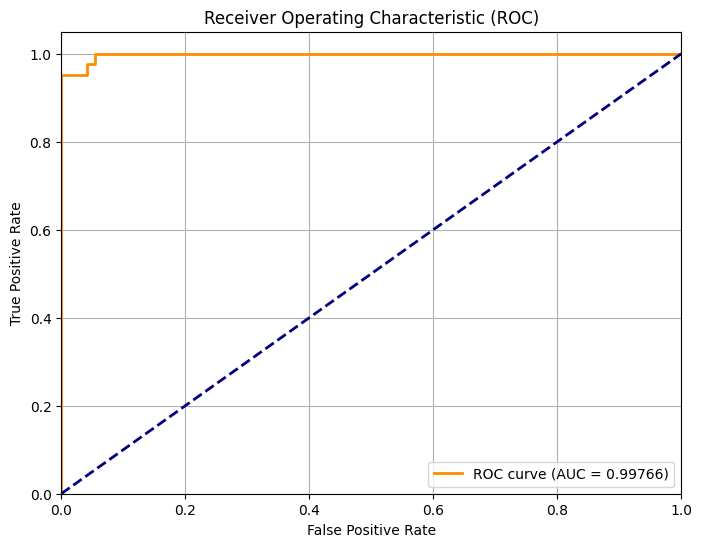

In [ ]:
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_std_lr_probs)
roc_auc3 = auc(fpr3, tpr3)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc3:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
logreg = LogisticRegression()

param_grid_logreg = {'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': np.arange(0,2, 0.01), 'class_weight': [None, 'balanced'], 'max_iter': range(1, 501), 'random_state': range(1,101)}
logr = RandomizedSearchCV(estimator = logreg, param_distributions = param_grid_logreg, cv = 5, n_jobs = -1, random_state = 42, return_train_score = True)
logr_result = logr.fit(X_train_std, y_train)
print("Best: %f using %s" % (logr_result.best_score_, logr_result.best_params_))
print(logr.best_estimator_.score(X_test_std, y_test))

Best: 0.982418 using {'solver': 'liblinear', 'random_state': 83, 'max_iter': 192, 'class_weight': None, 'C': np.float64(0.22)}
0.9736842105263158


In [ ]:
#Create new Logistic Regression classifier with new parameters
lrg = LogisticRegression(solver = 'liblinear', max_iter = 379, class_weight = None, C = 0.18,  random_state=83)
lrg.fit(X_train_std,y_train)
y_pred_train_tuned_lr = lrg.predict(X_train_std)
y_pred_std_tuned_lr = lrg.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_tuned_lr)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_std_tuned_lr)}")

Train Accuracy: 0.9846153846153847
Test Accuracy: 0.9736842105263158


In [ ]:
# Compute precision-recall pairs
precision4, recall4, _ = precision_recall_curve(y_test, y_pred_std_tuned_lr)

# Compute the area under the precision-recall curve
avg_precision4 = average_precision_score(y_test, y_pred_std_tuned_lr)

print(precision4)
print(recall4)

[0.35964912 1.         1.        ]
[1.         0.92682927 0.        ]


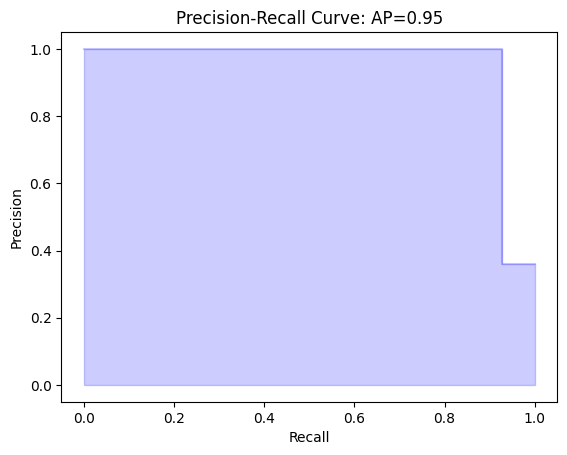

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall4, precision4, color='b', alpha=0.2, where='post')
plt.fill_between(recall4, precision4, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision4))
plt.show()

In [ ]:
y_pred_std_tuned_lr_probs = lrg.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_tuned_lr_probs)}")

AUC: 0.994988306047444


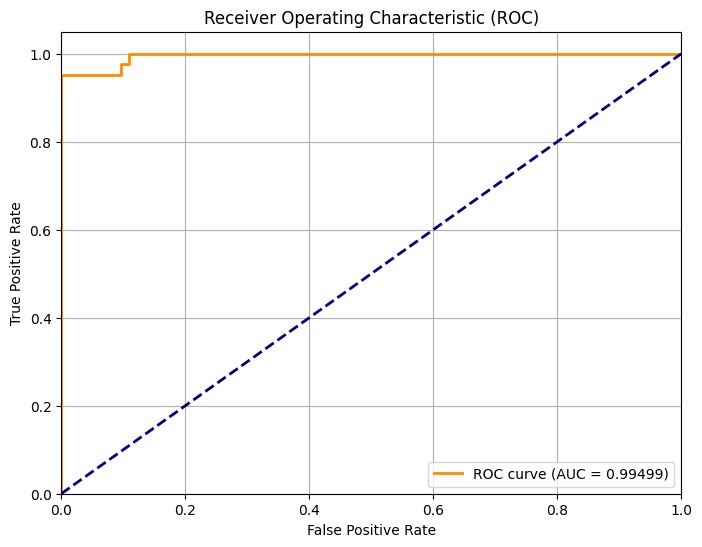

In [ ]:
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_std_tuned_lr_probs)
roc_auc4 = auc(fpr4, tpr4)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr4, tpr4, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc4:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

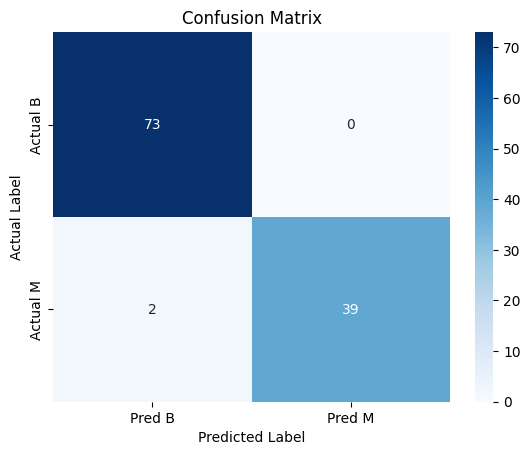

In [ ]:
#Confusion Matrix for default Logistic Regression
cm3 = confusion_matrix(y_test, y_pred_std_lr)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

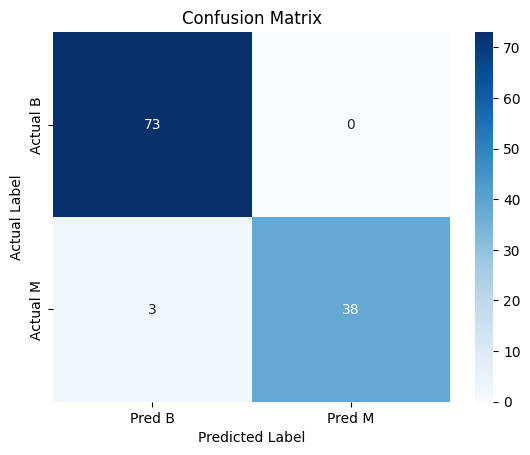

In [ ]:
#Confusion Matrix for tuned Logistic Regression
cm4 = confusion_matrix(y_test, y_pred_std_tuned_lr)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
TN, FP, FN, TP = cm3.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 1.000
Recall: 0.951
F1-Score: 0.97


In [ ]:
TN, FP, FN, TP = cm4.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 1.000
Recall: 0.927
F1-Score: 0.96


In [ ]:
weights = lr.coef_[0]
intercept = lr.intercept_[0]
feature_names = X_train.columns
sorted_features = sorted(zip(feature_names, weights), key=lambda x: abs(x[1]), reverse=True)
for f, w in sorted_features:
    print(f"{f}: {w:.4f}")
print(f"Intercept:", intercept)

concave points_worst: 1.4184
radius_worst: 1.1723
area_worst: 1.1054
perimeter_worst: 1.0609
smoothness_worst: 1.0055
concave points_mean: 0.9432
texture_worst: 0.9008
radius_se: 0.7650
compactness_mean: -0.7286
symmetry_worst: 0.6935
area_se: 0.6392
texture_mean: 0.5516
concavity_worst: 0.5373
concavity_mean: 0.4378
area_mean: 0.4214
perimeter_se: 0.3882
compactness_worst: -0.3867
radius_mean: 0.3577
perimeter_mean: 0.3482
concave points_se: -0.2889
Intercept: -0.1415751359752556


In [ ]:
weights = lrg.coef_[0]
intercept = lrg.intercept_[0]
feature_names = X_train.columns
sorted_features = sorted(zip(feature_names, weights), key=lambda x: abs(x[1]), reverse=True)
for f, w in sorted_features:
    print(f"{f}: {w:.4f}")
print(f"Intercept:", intercept)

concave points_worst: 0.7238
radius_worst: 0.6936
smoothness_worst: 0.6730
area_worst: 0.6580
texture_worst: 0.6441
perimeter_worst: 0.6427
concave points_mean: 0.5379
symmetry_worst: 0.4794
area_mean: 0.4528
radius_mean: 0.4367
perimeter_mean: 0.4197
texture_mean: 0.4151
radius_se: 0.4106
area_se: 0.3986
concavity_worst: 0.3337
concavity_mean: 0.3068
perimeter_se: 0.2916
compactness_mean: -0.1732
concave points_se: -0.1216
compactness_worst: -0.0103
Intercept: -0.29489922550620445


In [ ]:
#Shap
# Fits the explainer
explainer_log = shap.Explainer(lrg.predict, X_test_std)
shap_values_log = explainer_log(X_test_std)

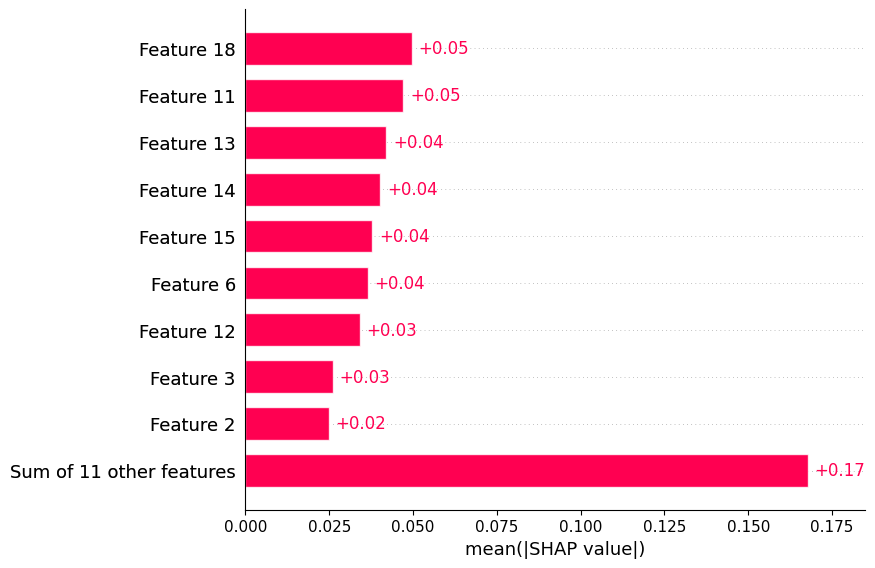

In [ ]:
shap.plots.bar(shap_values_log)

In [ ]:
X.columns[[18, 11, 13, 14, 15]]

Index(['concave points_worst', 'radius_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst'],
      dtype='object')

In [ ]:
## Logistic Regression with regularization based on Random Search Cross validation
## for hyperparameters from the same search space as for logististic regression
## above without regularization
param_dist = {'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': np.arange(0.01, 2, 0.01), 'class_weight': [None, 'balanced']}
#param_dist = {'C': np.arange(0.01, 2, 0.01)}
#from scipy.stats import uniform
#param_dist = {'C': uniform(loc=0, scale=4)}



In [ ]:
# Logistic Regression model with L2 penalty (Ridge)

logist_l2 = LogisticRegression(penalty='l2')

RS_L2_accuracy = RandomizedSearchCV(logist_l2, cv=5, n_jobs=-1,
    param_distributions=param_dist, n_iter=1000, random_state=42,
    scoring='accuracy')

RS_L2_recall = RandomizedSearchCV(logist_l2, cv=5, n_jobs=-1,
    param_distributions=param_dist, n_iter=1000, random_state=42,
    scoring='recall')

# Fit the random search to the data and get best model
RS_L2_accuracy.fit(X_train_std, y_train)
best_L2_accuracy = RS_L2_accuracy.best_estimator_

RS_L2_recall.fit(X_train_std, y_train)
best_L2_recall = RS_L2_recall.best_estimator_

# Confirm searches based on accuracy and recall score returns the same best model
print("Number of features with same coefficients from best model based on either accuracy or recall score:\n", sum(best_L2_recall.coef_.T==best_L2_accuracy.coef_.T))

# Print the best parameters and score
#print("Best L2 acurracy score:", RS_L2_accuracy.best_score_)
print("Best L2 parameters for acurracy:", RS_L2_accuracy.best_params_)
#print("Best L2 recall score:", RS_L2_recall.best_score_)
print("Best L2 parameters for recall:", RS_L2_recall.best_params_)

# Model predictions
y_pred_L2_train = best_L2_accuracy.predict(X_train_std)
y_pred_L2_test = best_L2_accuracy.predict(X_test_std)

# Evaluate the model
accuracy_train_L2 = accuracy_score(y_train, y_pred_L2_train)
recall_train_L2 = sum((y_train==y_pred_L2_train)*(y_train==1))/sum(y_train==1)

accuracy_test_L2 = accuracy_score(y_test, y_pred_L2_test)
recall_test_L2 = sum((y_test==y_pred_L2_test)*(y_test==1))/sum(y_test==1)
precision_test_L2 = sum((y_test==y_pred_L2_test)*(y_test==1))/sum(y_pred_L2_test==1)
f1_test_L2 = (2*precision_test_L2*recall_test_L2)/(precision_test_L2 + recall_test_L2)

print("Accuracy and recall of Ridge (L2) logistic regression on training data:", accuracy_train_L2, recall_train_L2)
print("Accuracy and recall of Ridge (L2) logistic regression on test data:", accuracy_test_L2, recall_test_L2)

print("L2 Norm of coefficients vector from the best model with L2 regularization: ", np.linalg.norm(best_L2_accuracy.coef_, ord=2))
print("L2 Norm of coefficients vector from the best logistic regression model without regularization: ", np.linalg.norm(lrg.coef_, ord=2))




Number of features with same coefficients from best model based on either accuracy or recall score:
 [0]
Best L2 parameters for acurracy: {'solver': 'liblinear', 'class_weight': None, 'C': np.float64(0.09)}
Best L2 parameters for recall: {'solver': 'liblinear', 'class_weight': 'balanced', 'C': np.float64(0.18000000000000002)}
Accuracy and recall of Ridge (L2) logistic regression on training data: 0.9824175824175824 0.9649122807017544
Accuracy and recall of Ridge (L2) logistic regression on test data: 0.9736842105263158 0.926829268292683
L2 Norm of coefficients vector from the best model with L2 regularization:  1.7565760555556749
L2 Norm of coefficients vector from the best logistic regression model without regularization:  2.155244205825036


In [ ]:
weights_L2 = best_L2_accuracy.coef_[0]
intercept_L2 = best_L2_accuracy.intercept_[0]
feature_names = X_train.columns
sorted_features_L2 = sorted(zip(feature_names, weights_L2), key=lambda x: abs(x[1]), reverse=True)
for f, w in sorted_features_L2:
    print(f"{f}: {w:.4f}")
print(f"Intercept:", intercept_L2)

radius_worst: 0.5566
concave points_worst: 0.5550
area_worst: 0.5265
perimeter_worst: 0.5219
texture_worst: 0.5219
smoothness_worst: 0.5211
concave points_mean: 0.4397
area_mean: 0.4019
radius_mean: 0.3958
symmetry_worst: 0.3936
perimeter_mean: 0.3835
texture_mean: 0.3569
area_se: 0.3255
radius_se: 0.3252
concavity_worst: 0.2746
concavity_mean: 0.2625
perimeter_se: 0.2516
concave points_se: -0.0819
compactness_worst: 0.0758
compactness_mean: -0.0412
Intercept: -0.2980510283514988


In [ ]:
## Include all original features for feature selection based on the same seed(14) for train/test split

Xa = df.drop(columns= ['diagnosis'])
y = df['diagnosis'].values
Xa_train, Xa_test, y_train, y_test = train_test_split(Xa, y, test_size=0.2, random_state=14)

#Standardize all features Xa
sc = StandardScaler()
sc.fit(Xa_train)
Xa_train_std = sc.transform(Xa_train)
Xa_test_std = sc.transform(Xa_test)
Xa_train_std.shape

(455, 30)

In [ ]:
# LASSO logistic regression for feature selection
#param_dist = {'C': np.arange(0.01, 2, 0.01)}
from scipy.stats import uniform
param_dist = {'C': uniform(loc=0, scale=4)}

logist_l1 = LogisticRegression(penalty='l1', solver='liblinear')

RS_L1_accuracy = RandomizedSearchCV(logist_l1, cv=5, n_jobs=-1,
    param_distributions=param_dist, n_iter=1000, random_state=42,
    scoring='accuracy')

RS_L1_recall = RandomizedSearchCV(logist_l1, cv=5, n_jobs=-1,
    param_distributions=param_dist, n_iter=1000, random_state=42,
    scoring='recall')

# Fit the random search to the data and get best model
RS_L1_accuracy.fit(Xa_train_std, y_train)
best_L1_accuracy = RS_L1_accuracy.best_estimator_

RS_L1_recall.fit(Xa_train_std, y_train)
best_L1_recall = RS_L1_recall.best_estimator_

# Confirm searches based on accuracy and recall score returns the same best model
print("Number of features with same coefficients from best model based on either accuracy or recall score:\n", sum(best_L1_recall.coef_.T==best_L1_accuracy.coef_.T))

# Print the best parameters and score
#print("Best L1 acurracy score:", RS_L1_accuracy.best_score_)
print("Best L1 parameters for acurracy:", RS_L1_accuracy.best_params_)
#print("Best L1 recall score:", RS_L1_recall.best_score_)
print("Best L1 parameters for recall:", RS_L1_recall.best_params_)

# Coefficients from the best LASSO model

#print("Coefficients vector from the best model with L1 regularization:\n ", best_L1_accuracy.coef_)

weights_L1 = best_L1_accuracy.coef_[0]
intercept_L1 = best_L1_accuracy.intercept_[0]
feature_names = Xa_train.columns
sorted_features_L1 = sorted(zip(feature_names, weights_L1), key=lambda x: abs(x[1]), reverse=True)
for f, w in sorted_features_L1:
    print(f"{f}: {w:.4f}")
print(f"Intercept:", intercept_L1)

L1_selected = Xa_test.columns[np.where(best_L1_accuracy.coef_.T!=0)[0]]
print("\nFeatures selected with the best LASSO model for accuracy:\n", L1_selected)

L1_selected_recall = Xa_test.columns[np.where(best_L1_recall.coef_.T!=0)[0]]
print("\nFeatures selected with the best LASSO model for recall:\n", L1_selected_recall)

# Model predictions
y_pred_L1_train = best_L1_accuracy.predict(Xa_train_std)
y_pred_L1_test = best_L1_accuracy.predict(Xa_test_std)

# Evaluate the model
accuracy_train_L1 = accuracy_score(y_train, y_pred_L1_train)
recall_train_L1 = sum((y_train==y_pred_L1_train)*(y_train==1))/sum(y_train==1)

accuracy_test_L1 = accuracy_score(y_test, y_pred_L1_test)
recall_test_L1 = sum((y_test==y_pred_L1_test)*(y_test==1))/sum(y_test==1)
precision_test_L1 = sum((y_test==y_pred_L1_test)*(y_test==1))/sum(y_pred_L1_test==1)
f1_test_L1 = (2*precision_test_L1*recall_test_L1)/(precision_test_L1 + recall_test_L1)

print("Accuracy and recall of LASSO (L1) logistic regression on training data:", accuracy_train_L1, recall_train_L1)
print("Accuracy and recall of LASSO (L1) logistic regression on test data:", accuracy_test_L1, recall_test_L1)

print("L2 Norm of coefficients vector from the best model with L1 regularization: ", np.linalg.norm(best_L1_accuracy.coef_, ord=2))
print("L2 Norm of coefficients vector from the best logistic regression model without regularization: ", np.linalg.norm(lrg.coef_, ord=2))




Number of features with same coefficients from best model based on either accuracy or recall score:
 [20]
Best L1 parameters for acurracy: {'C': np.float64(0.2982025747190833)}
Best L1 parameters for recall: {'C': np.float64(0.048617898759265366)}
Coefficients vector from the best model with L1 regularization:
  [[0.         0.15810728 0.         0.         0.         0.
  0.15643276 0.57102541 0.         0.         0.44333563 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.44834899 0.84975134 0.         3.59265542
  0.50467519 0.         0.         1.16597292 0.36444664 0.        ]]
area_worst: 3.5927
concave points_worst: 1.1660
texture_worst: 0.8498
concave points_mean: 0.5710
smoothness_worst: 0.5047
radius_worst: 0.4483
radius_se: 0.4433
symmetry_worst: 0.3644
texture_mean: 0.1581
concavity_mean: 0.1564
radius_mean: 0.0000
perimeter_mean: 0.0000
area_mean: 0.0000
smoothness_mean: 0.0000
compactness_mean: 0.0000
symmetry_mean: 0.0000
fractal

Historgram of features selected based on the best model LASSO for accuracy


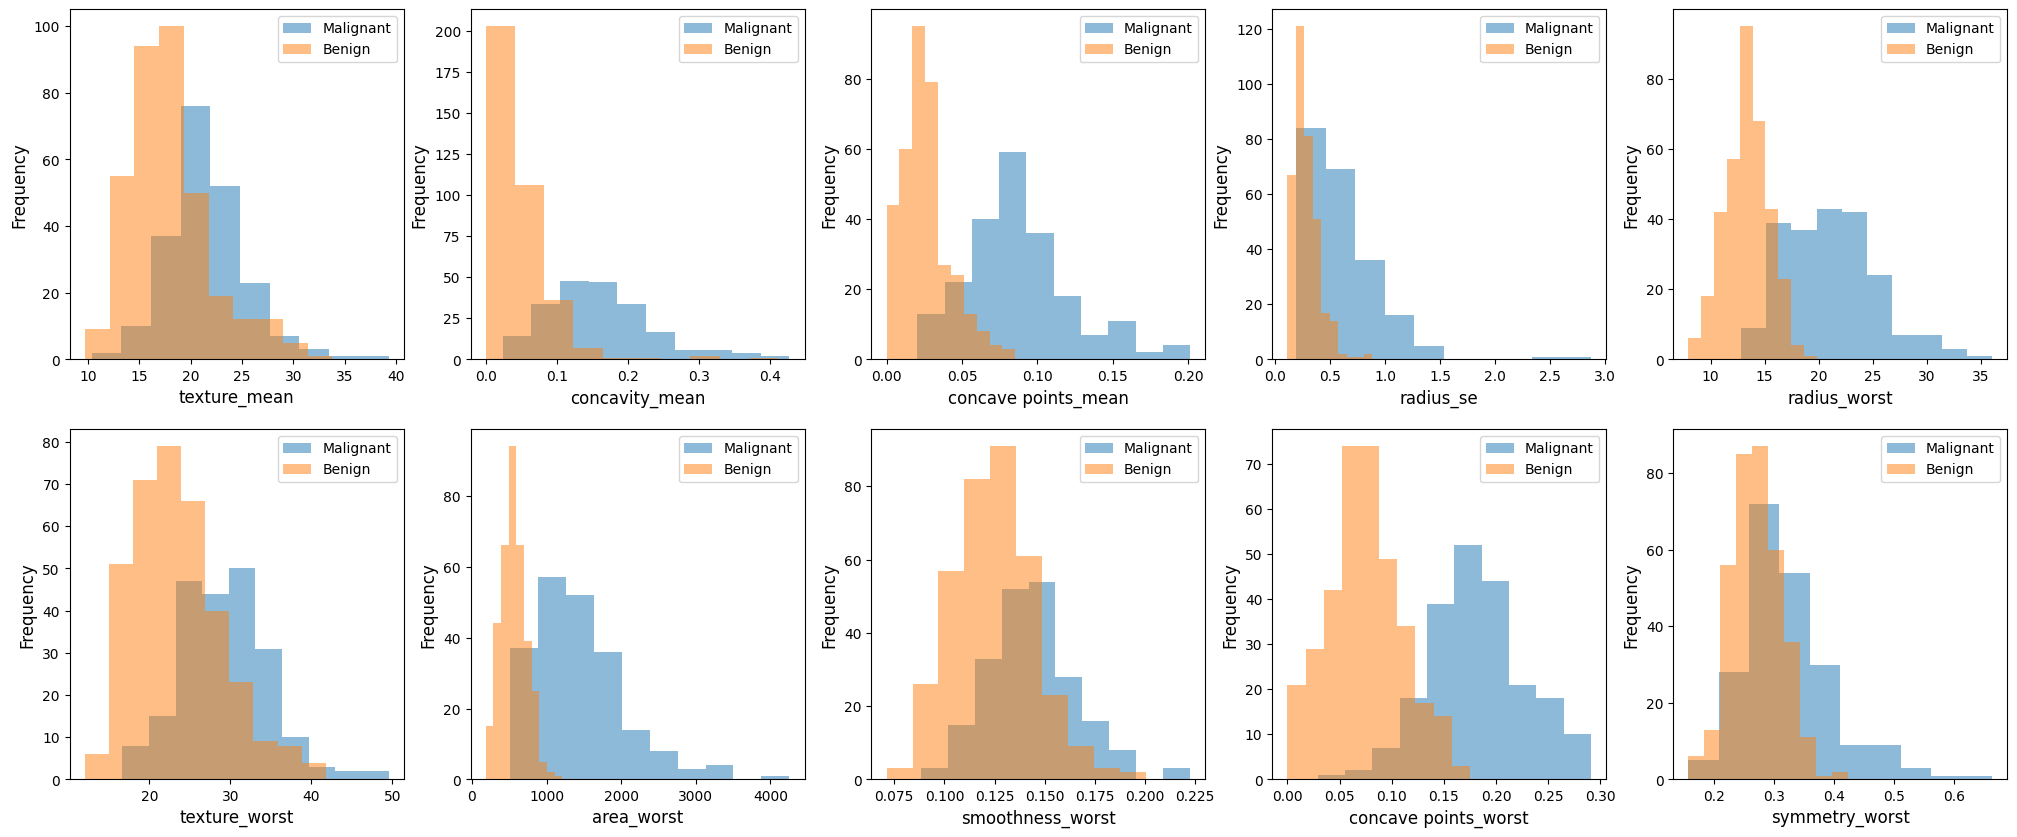

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
dfsel = df.filter(items=L1_selected)
for i, (name, values) in enumerate(dfsel.items()):
    for cdiag in df['diagnosis'].unique():
        dlabl="Malignant" if cdiag==1 else "Benign"
        axes[int(i/5), i%5].hist(dfsel[df['diagnosis'] == cdiag][name], label=dlabl, alpha=0.5)
        #axes[int(i/5), i%5].set_title(f'Histogram of {name}', fontsize=12)
        axes[int(i/5), i%5].set_xlabel(f'{name}', fontsize=12)
        axes[int(i/5), i%5].set_ylabel(f'Frequency', fontsize=12)
        axes[int(i/5), i%5].legend()
print(f"Historgram of features selected based on the best model LASSO for prediction accuracy of diagnosis")


In [ ]:
# Random Forest non-parametric fit based on all 30 original features for
# feature selection by normalized importance score calcualted based on
# weighted information gain for each feature.

scale01 = MinMaxScaler()

param_grid_rf = {
    'n_estimators': range(10,200,10), 'criterion' :['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'], 'max_depth' : list(range(1, 10)) + [None]
}

# Fit Random Forest model with all 30 original features and cross validation

rf = RandomForestClassifier()
rfr = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, cv = 5, n_iter=100, n_jobs = -1, random_state = 42, return_train_score = True)
rfr_result = rfr.fit(Xa_train_std, y_train)

# Get feature importances
importance = rfr_result.best_estimator_.feature_importances_
importance_normalized = scale01.fit_transform(importance.reshape(-1, 1)).flatten()
importances = pd.DataFrame({
    'Feature': Xa_train.columns,
    'Importance': importance,
    'Importance_normalized': importance_normalized
})
RF_importances = importances.sort_values(by='Importance_normalized', ascending=False)

print("feature importance index based on information gain in Random Forests\n", RF_importances)

#y_pred_RF = rfr_result.best_estimator_.predict(Xa_test_std)
# Select features above a certain normalized importance threshold (e.g., 0.5)
#threshold = 0.5
#selected_features = feature_importance_df[feature_importance_df['Normalized Importance'] >= threshold]['Feature'].tolist()

#print("\nSelected Features (threshold >= 0.5):")
#print(selected_features)

feature importance index based on information gain in Random Forests                     Feature  Importance  Importance_normalized
20             radius_worst    0.134138               1.000000
22          perimeter_worst    0.111321               0.824621
27     concave points_worst    0.108454               0.802582
7       concave points_mean    0.079379               0.579102
23               area_worst    0.078714               0.573989
6            concavity_mean    0.060362               0.432929
2            perimeter_mean    0.058529               0.418841
0               radius_mean    0.056666               0.404516
3                 area_mean    0.046935               0.329722
26          concavity_worst    0.036592               0.250221
21            texture_worst    0.026063               0.169288
25        compactness_worst    0.024021               0.153598
1              texture_mean    0.018140               0.108389
13                  area_se    0.016495          

In [ ]:
features_in = [*range(0,30)]

In [ ]:
# Feature selection by greedy feature elimination process with
# best SVM classifier based on

from scipy.stats import uniform, randint

param_dist_svm = {
        'C': range(0.1, 10, 0.1),
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', range(0.01, 1, 0.01)],
        'degree': randint(2, 5)
    }
svm = SVC()
svm_search = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=100, cv=5,
        n_jobs=-1, scoring='accuracy', random_state=42)

accuracy_svm = []
features = [*range(0,29)]
for f in features:

    svm_result = svm_search.fit(Xa_train_std[:,features.remove(f)], y_train)

    y_pred_svm = svm_result.predict(Xa_test[:,active_attributes])

    correct_answers.append(sum(predicted_output - y_test == 0))

    active_attributes.append(j)   # add j

print(correct_answers)










print("Best hyperparameters:", random_search.best_params_)

print("Best score:", random_search.best_score_)

best_svm = random_search.best_estimator_

accuracy_svm = best_svm.score(x_test_std, y_test)

print("SVM accuracy:", accuracy_svm)

#best_svm.predict(x_test_std)



f=11
fidx = [*range(0,29)]
active_attributes.remove(j)
print(active_attributes)

X1 = X_train[:,active_attributes]
X1.shape

correct_answers = []
active_attributes = [*range(0,13)]

print(active_attributes)


for j in active_attributes:

    active_attributes.remove(j)    # remove j

    knn.fit(X_train[:,active_attributes], y_train)
    predicted_output = knn.predict(X_test[:,active_attributes])

    correct_answers.append(sum(predicted_output - y_test == 0))

    active_attributes.append(j)   # add j

print(correct_answers)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([['g1','c1',10],['g1','c2',12],['g1','c3',13],['g2','c1',8],
                   ['g2','c2',10],['g2','c3',12]],columns=['group','column','val'])

df.pivot("column", "group", "val").plot(kind='bar')

plt.show()
categories = ['A', 'B', 'C', 'D']
values = [4, 7, 1, 8]

# Create the bar chart
plt.bar(categories, values, color='skyblue')

# Add title and labels
plt.title('Sample Bar Chart')
plt.xlabel('Categories')
plt.ylabel('Values')

# Show the plot
plt.show()

In [ ]:
corr_values = abs(df.corr()["diagnosis"])
corr_values.sort_values(ascending=False)
relevant_features

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0.012838
texture_se                 0.008303
symmetry_se                0.006522
Name: diagnosis, dtype: float64

In [ ]:
##Neural Network

In [ ]:
mlp = MLPClassifier()
mlp.fit(X_train_std, y_train)
y_pred_train_nn = mlp.predict(X_train_std)
y_pred_std_nn = mlp.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train,y_pred_train_nn)}")
print(f"Test Accuracy: {accuracy_score(y_test,y_pred_std_nn)}")
#output indicates that with the maximum iterations = 200, the algorithm still hasn't converged.

Train Accuracy: 0.9934065934065934
Test Accuracy: 0.9912280701754386


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Compute precision-recall pairs
precision5, recall5, _ = precision_recall_curve(y_test, y_pred_std_nn)
avg_precision5 = average_precision_score(y_test, y_pred_std_nn)
print(precision5)
print(recall5)

[0.35964912 1.         1.        ]
[1.         0.97560976 0.        ]


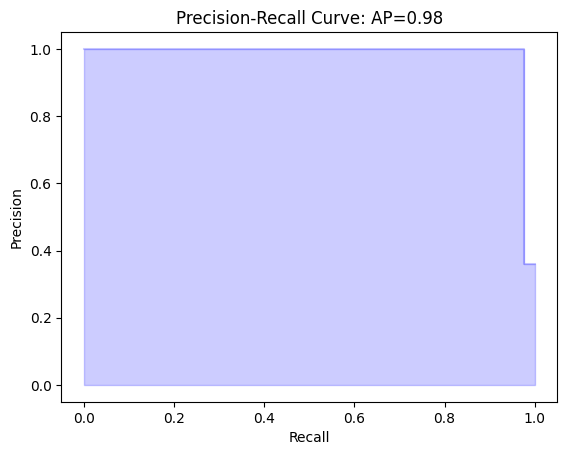

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall5, precision5, color='b', alpha=0.2, where='post')
plt.fill_between(recall5, precision5, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision5))
plt.show()

In [ ]:
y_pred_std_nn_probs = mlp.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_nn_probs)}")

AUC: 0.9986635482793184


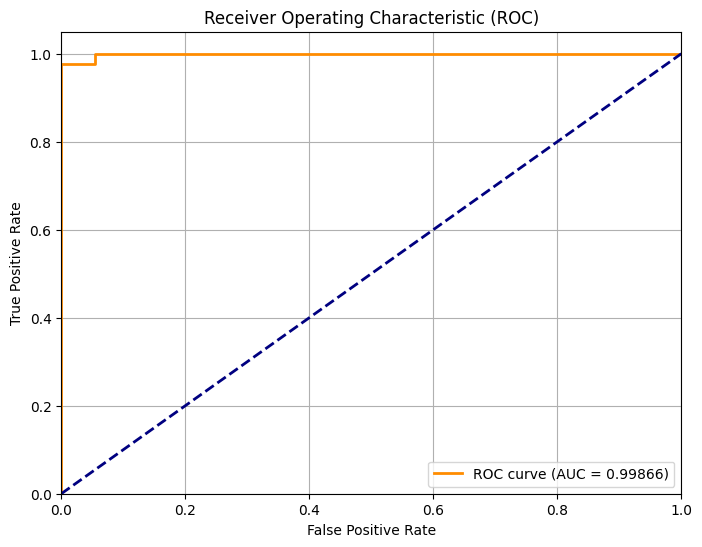

In [ ]:
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_std_nn_probs)
roc_auc5 = auc(fpr5, tpr5)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr5, tpr5, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc5:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
nn = MLPClassifier()

param_grid_nn = {'activation': ['identity', 'logistic', 'relu', 'tanh'], 'solver': ['lbfgs', 'adam', 'sgd'],
                 'alpha': np.arange(0, 1, 0.0001), 'learning_rate_init': np.arange(0, 1, 0.001),
                 'learning_rate': ['constant', 'invscaling', 'adaptive'],  'random_state': range(1,101)}
nnr = RandomizedSearchCV(estimator = nn, param_distributions = param_grid_nn, cv = 5, n_jobs = -1, random_state = 42, return_train_score = True)
nnr_result = nnr.fit(X_train_std, y_train)
print("Best: %f using %s" % (nnr_result.best_score_, nnr_result.best_params_))
print(nnr.best_estimator_.score(X_test_std, y_test))

Best: 0.982418 using {'solver': 'adam', 'random_state': 95, 'learning_rate_init': np.float64(0.033), 'learning_rate': 'invscaling', 'alpha': np.float64(0.4998), 'activation': 'logistic'}
0.9824561403508771


In [ ]:
#Create new Neural Network classifier with new parameters
netw = MLPClassifier(solver = 'adam', learning_rate_init = 0.033, learning_rate = 'invscaling', alpha = 0.4998, activation = 'logistic', random_state=95)
netw.fit(X_train_std, y_train)
y_pred_train_tuned_nn = netw.predict(X_train_std)
y_pred_std_tuned_nn = netw.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_tuned_nn)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_std_tuned_nn)}")

Train Accuracy: 0.9824175824175824
Test Accuracy: 0.9824561403508771


In [ ]:
# Compute precision-recall pairs
precision6, recall6, _ = precision_recall_curve(y_test, y_pred_std_tuned_nn)
avg_precision6 = average_precision_score(y_test, y_pred_std_tuned_nn)
print(precision6)
print(recall6)

[0.35964912 1.         1.        ]
[1.         0.95121951 0.        ]


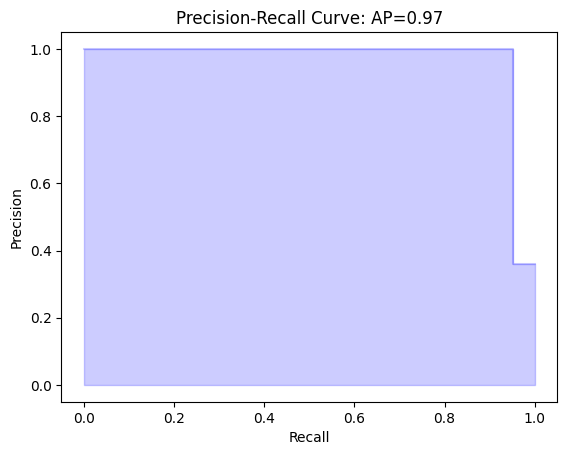

In [ ]:
# Plot the Precision-Recall curve
plt.step(recall6, precision6, color='b', alpha=0.2, where='post')
plt.fill_between(recall6, precision6, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(avg_precision6))
plt.show()

In [ ]:
y_pred_std_tuned_nn_probs = netw.predict_proba(X_test_std)[:, 1]
print(f"AUC: {roc_auc_score(y_test, y_pred_std_tuned_nn_probs)}")

AUC: 0.9953224189776144


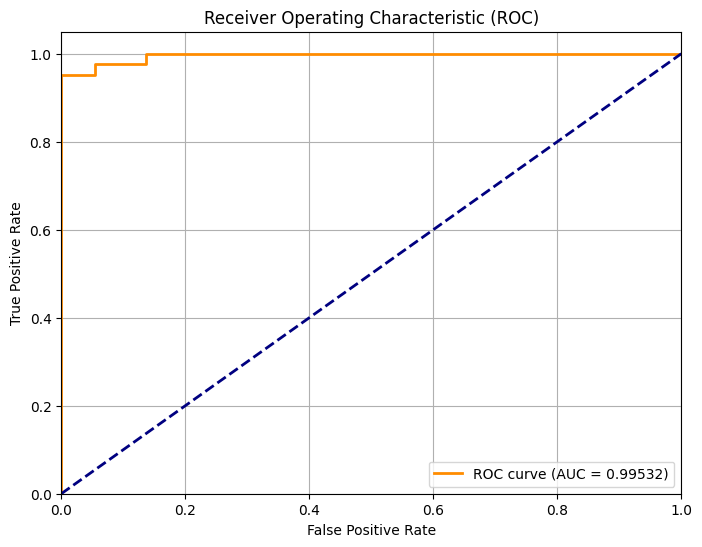

In [ ]:
fpr6, tpr6, thresholds6 = roc_curve(y_test, y_pred_std_tuned_nn_probs)
roc_auc6 = auc(fpr6, tpr6)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr6, tpr6, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc6:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

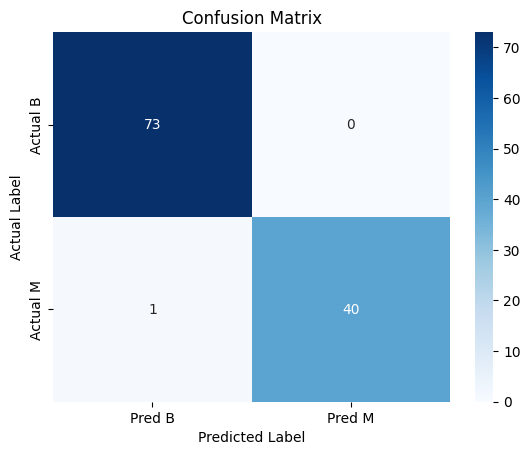

In [ ]:
#Confusion Matrix for default Neural Network
cm5 = confusion_matrix(y_test, y_pred_std_nn)
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

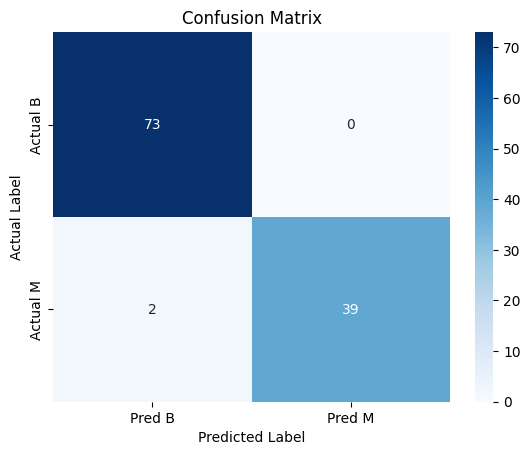

In [ ]:
#Confusion Matrix for default Neural Network
cm6 = confusion_matrix(y_test, y_pred_std_tuned_nn)
sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
TN, FP, FN, TP = cm5.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 1.000
Recall: 0.976
F1-Score: 0.99


In [ ]:
TN, FP, FN, TP = cm6.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 1.000
Recall: 0.951
F1-Score: 0.97


In [ ]:
#Shap
# Fits the explainer
explainer_nn = shap.Explainer(netw.predict, X_test_std)
shap_values_nn = explainer_nn(X_test_std)

PermutationExplainer explainer: 115it [00:20,  2.87it/s]


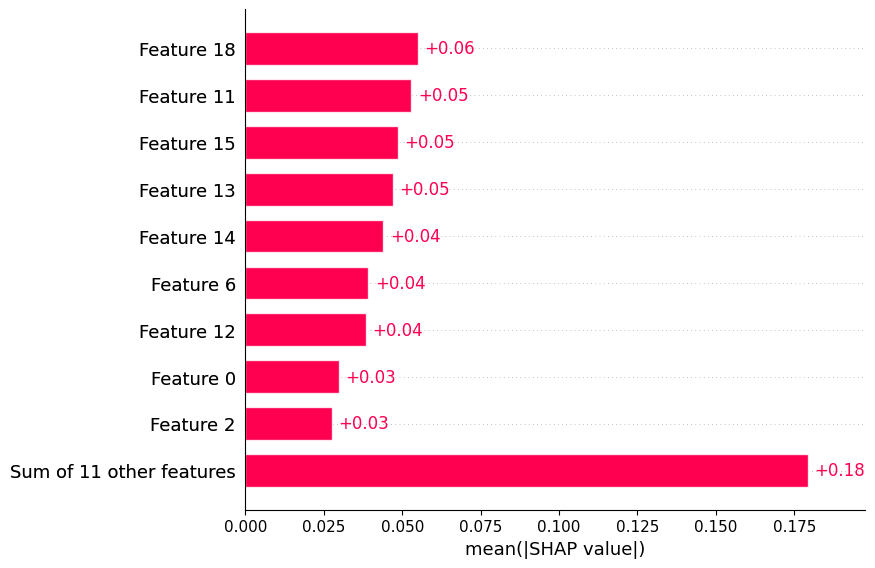

In [ ]:
shap.plots.bar(shap_values_nn)

In [ ]:
X.columns[[18, 11, 13, 14, 12]]

Index(['concave points_worst', 'radius_worst', 'perimeter_worst', 'area_worst',
       'texture_worst'],
      dtype='object')

In [ ]:
rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': range(10,200,10), 'criterion' :['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'], 'max_depth' : list(range(1, 10)) + [None],
    'random_state': range(1,100),
}

rfr = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, cv = 5, n_jobs = -1, random_state = 42, return_train_score = True)
rfr_result = rfr.fit(X_train_std, y_train)
print("Best: %f using %s" % (rfr_result.best_score_, rfr_result.best_params_))
print(rfr.best_estimator_.score(X_test_std, y_test))

Best: 0.962637 using {'random_state': 42, 'n_estimators': 30, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'log_loss'}
0.9736842105263158


In [ ]:
#Create new Random Forest Classifier with new parameters
randfor = RandomForestClassifier(random_state=42,n_estimators=30,max_features='log2',max_depth=8,criterion='log_loss')
randfor.fit(X_train_std, y_train)
y_pred_train_tuned_rf = randfor.predict(X_train_std)
y_pred_std_tuned_rf = randfor.predict(X_test_std)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_tuned_rf)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_std_tuned_rf)}")

Train Accuracy: 1.0
Test Accuracy: 0.9736842105263158


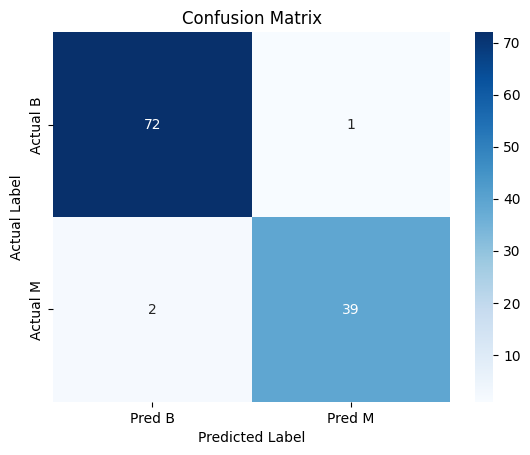

In [ ]:
cm7 = confusion_matrix(y_test, y_pred_std_tuned_rf)
sns.heatmap(cm7, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred B', 'Pred M'], yticklabels=['Actual B', 'Actual M'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

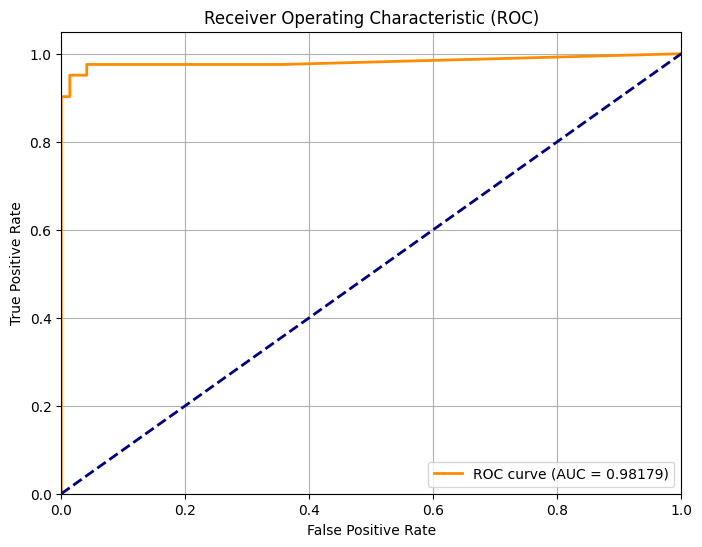

In [ ]:
y_pred_std_tuned_rf_probs = randfor.predict_proba(X_test_std)[:, 1]
fpr7, tpr7, thresholds7 = roc_curve(y_test, y_pred_std_tuned_rf_probs)
roc_auc7 = auc(fpr7, tpr7)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr7, tpr7, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc7:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
TN, FP, FN, TP = cm7.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall)/(precision+recall)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.975
Recall: 0.951
F1-Score: 0.96


PermutationExplainer explainer: 115it [00:18,  2.51it/s]


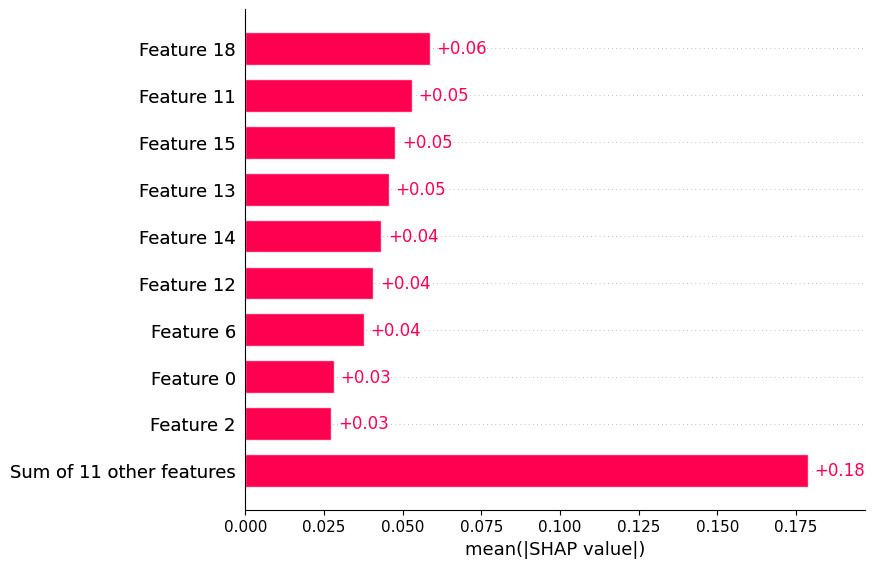

In [ ]:
#Shap
# Fits the explainer
explainer_rf = shap.Explainer(randfor.predict, X_test_std)
shap_values_rf = explainer_nn(X_test_std)
shap.plots.bar(shap_values_rf)

In [ ]:
X.columns[[18, 11, 15, 13]]

Index(['concave points_worst', 'radius_worst', 'smoothness_worst',
       'perimeter_worst'],
      dtype='object')

In [64]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv1 = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': range(1, 20, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [30, 40, 50],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=knn_params,
    cv=cv,
    verbose=1,
    scoring='roc_auc'
)

# Train on SCALED training data
grid_result_knn = grid_search_knn.fit(X_train_std, y_train)
print("Best Parameters:", grid_result_knn.best_params_)



Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best Parameters: {'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


In [65]:
# Final evaluation on SCALED test data
best_knn = grid_result_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_std)

print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_knn):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}')

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        73
           1       0.97      0.93      0.95        41

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

[[72  1]
 [ 3 38]]
ROC-AUC: 0.9566
Accuracy: 0.9649


In [19]:
# Training and Test Accuracies for KNN
train_acc_knn = best_knn.score(X_train_std, y_train)
test_acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Training Accuracy: {train_acc_knn:.4f}")
print(f"KNN Test Accuracy: {test_acc_knn:.4f}\n")

KNN Training Accuracy: 1.0000
KNN Test Accuracy: 0.9649



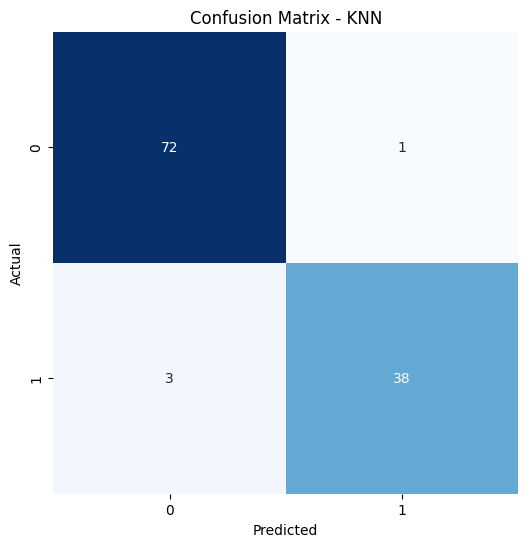

In [20]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6,6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Calculate metrics
TN_knn, FP_knn, FN_knn, TP_knn = cm_knn.ravel()
precision_knn = TP_knn / (TP_knn + FP_knn)
recall_knn = TP_knn / (TP_knn + FN_knn)
f1_knn = (2 * precision_knn * recall_knn) / (precision_knn + recall_knn)
print("KNN Metrics:")
print(f"Precision: {precision_knn:.3f}")
print(f"Recall: {recall_knn:.3f}")
print(f"F1-Score: {f1_knn:.3f}\n")

KNN Metrics:
Precision: 0.974
Recall: 0.927
F1-Score: 0.950



Train Accuracy for tuned model: 1.0
Test Accuracy for tuned model: 0.9649122807017544
Confusion Matrix:
 [[72  1]
 [ 3 38]]


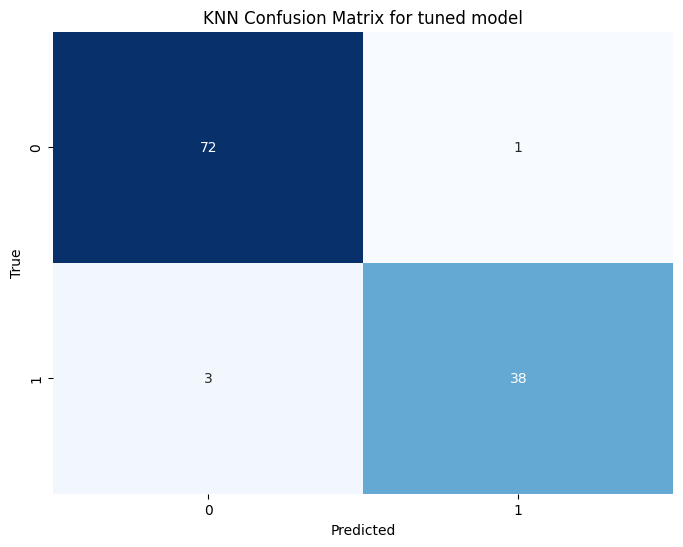

In [48]:
# Extract best parameters
best_knn_params = grid_result_knn.best_params_

# Create and train a new KNN model with best parameters
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train_std, y_train)


y_pred_train = best_knn_model.predict(X_train_std)
y_pred_test = best_knn_model.predict(X_test_std)


train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy for tuned model: {train_acc}")
print(f"Test Accuracy for tuned model: {test_acc}")

# Confusion matrix
cm_knn1 = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm_knn1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix for tuned model')
plt.show()

In [41]:
TN_knn, FP_knn, FN_knn, TP_knn = cm_knn1.ravel()
precision_knn = TP_knn / (TP_knn + FP_knn)
recall_knn = TP_knn / (TP_knn + FN_knn)
f1_knn = (2 * precision_knn * recall_knn) / (precision_knn + recall_knn)
print("Tuned KNN Metrics:")
print(f"Precision: {precision_knn:.3f}")
print(f"Recall: {recall_knn:.3f}")
print(f"F1-Score: {f1_knn:.3f}\n")

Tuned ]KNN Metrics:
Precision: 0.974
Recall: 0.927
F1-Score: 0.950



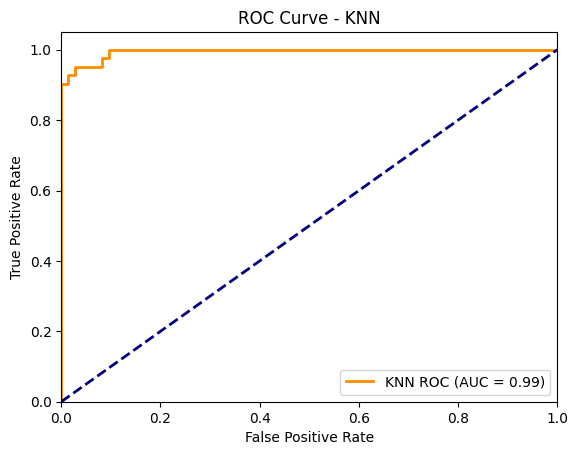

In [33]:
y_proba_knn = best_knn_model.predict_proba(X_test_std)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)


# ROC Curve for KNN
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'KNN ROC (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()


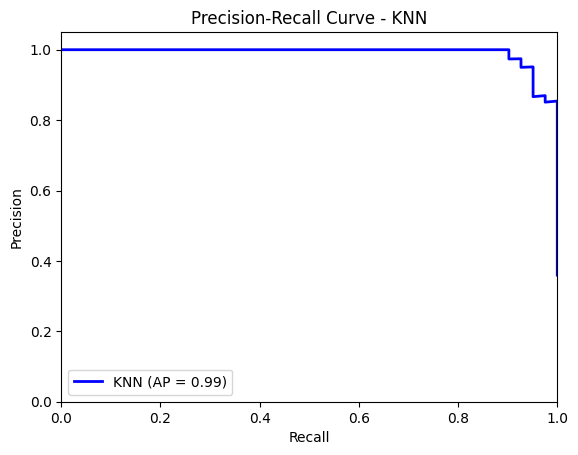

In [34]:
# Precision-Recall Curve for KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
avg_precision_knn = average_precision_score(y_test, y_proba_knn)
plt.figure()
plt.plot(recall_knn, precision_knn, color='blue', lw=2, label=f'KNN (AP = {avg_precision_knn:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - KNN')
plt.legend(loc="lower left")
plt.show()

PermutationExplainer explainer: 115it [02:14,  1.24s/it]


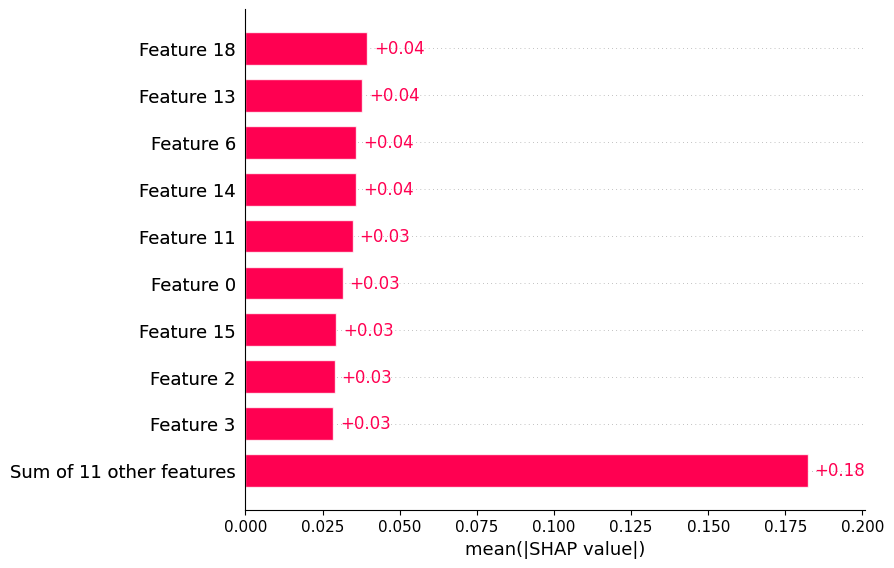

In [35]:
#SHAP-values for KNN
explainer_log = shap.Explainer(best_knn_model.predict, X_test_std)
shap_values_log = explainer_log(X_test_std)
shap.plots.bar(shap_values_log)


In [42]:
X.columns[[13, 18, 6, 11, 14]]

Index(['perimeter_worst', 'concave points_worst', 'concave points_mean',
       'radius_worst', 'area_worst'],
      dtype='object')

In [45]:
# Support Vector Machine (SVM) with GridSearch
svm = SVC(probability=True, random_state=42)
svm_params = {
    'C': [0.1, 1, 10, 100,1000],
    'gamma': ['scale', 'auto', 0.1, 0.03,0.001, 0.0001],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=svm_params,
    cv=cv1,
    scoring='roc_auc',
    verbose=1
)

# Train on scaled data
grid_result_svm = grid_search_svm.fit(X_train_std, y_train)
print("\nBest SVM Parameters:", grid_result_svm.best_params_)



Fitting 9 folds for each of 120 candidates, totalling 1080 fits

Best SVM Parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


In [46]:
# Evaluate on test set
best_svm = grid_result_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_std)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_svm):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}')


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        73
           1       1.00      0.95      0.97        41

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

SVM Confusion Matrix:
[[73  0]
 [ 2 39]]
ROC-AUC: 0.9756
Accuracy: 0.9825


In [47]:
# Training and Test Accuracies for SVM
train_acc_svm = best_svm.score(X_train_std, y_train)
test_acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Training Accuracy: {train_acc_svm:.4f}")
print(f"SVM Test Accuracy: {test_acc_svm:.4f}")

SVM Training Accuracy: 0.9846
SVM Test Accuracy: 0.9825


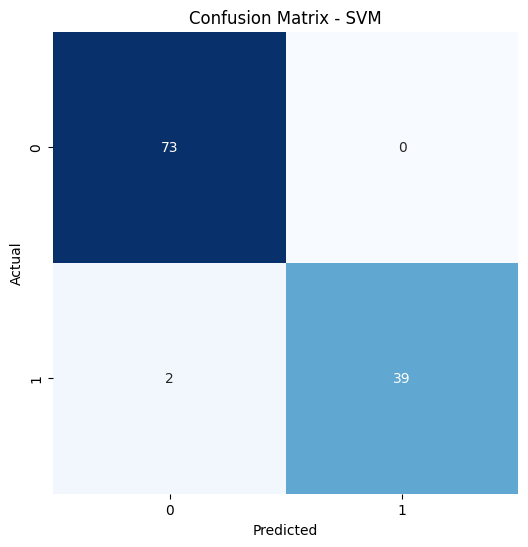

In [49]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
# Calculate metrics
TN_svm, FP_svm, FN_svm, TP_svm = cm_svm.ravel()
precision_svm = TP_svm / (TP_svm + FP_svm)
recall_svm = TP_svm / (TP_svm + FN_svm)
f1_svm = (2 * precision_svm * recall_svm) / (precision_svm + recall_svm)

print("SVM Metrics:")
print(f"Precision: {precision_svm:.3f}")
print(f"Recall: {recall_svm:.3f}")
print(f"F1-Score: {f1_svm:.3f}")

SVM Metrics:
Precision: 1.000
Recall: 0.951
F1-Score: 0.975


Best SVM Parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}

Tuned SVM Training Performance:
Train Accuracy: 0.9846

Tuned SVM Test Performance:
Test Accuracy: 0.9825
ROC-AUC: 0.9980
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        73
           1       1.00      0.95      0.97        41

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Test Confusion Matrix:
[[73  0]
 [ 2 39]]


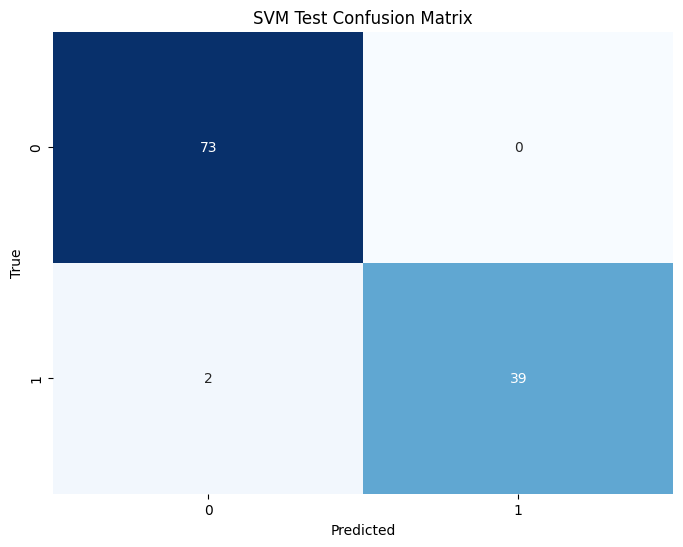

In [55]:
# Extract best parameters from GridSearch
best_svm_params = grid_result_svm.best_params_
print("Best SVM Parameters:", best_svm_params)

#Create a new SVM with best parameters
best_svm_model = SVC(
    **best_svm_params,
    probability=True,
    random_state=42
)


best_svm_model.fit(X_train_std, y_train)


y_pred_train_svm = best_svm_model.predict(X_train_std)
y_pred_test_svm = best_svm_model.predict(X_test_std)

y_proba_svm = best_svm_model.predict_proba(X_test_std)[:, 1]

# Calculate metrics
print("\nTuned SVM Training Performance:")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_svm):.4f}")


print("\nTuned SVM Test Performance:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_svm):.4f}")
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_svm):.4f}')
print(classification_report(y_test, y_pred_test_svm))
print("Test Confusion Matrix:")
cm_svm1 = confusion_matrix(y_test, y_pred_test_svm)
print(cm_svm1)

# Optional: Visualize test confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test_svm),
            annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Test Confusion Matrix')
plt.show()

In [56]:
# Calculate metrics
TN_svm, FP_svm, FN_svm, TP_svm = cm_svm1.ravel()
precision_svm = TP_svm / (TP_svm + FP_svm)
recall_svm = TP_svm / (TP_svm + FN_svm)
f1_svm = (2 * precision_svm * recall_svm) / (precision_svm + recall_svm)

print("Tuned SVM Metrics:")
print(f"Precision: {precision_svm:.3f}")
print(f"Recall: {recall_svm:.3f}")
print(f"F1-Score: {f1_svm:.3f}")

SVM Metrics:
Precision: 1.000
Recall: 0.951
F1-Score: 0.975


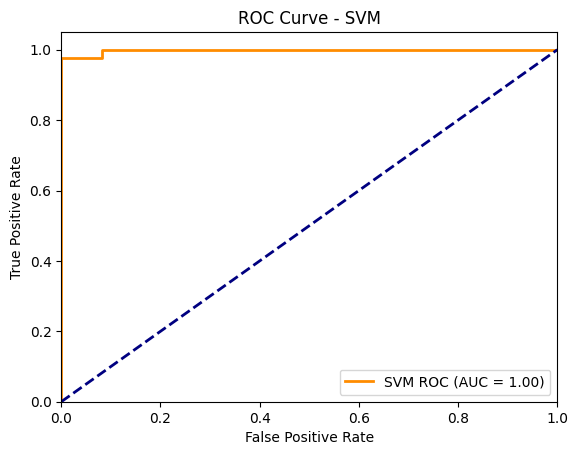

In [59]:
y_proba_svm_tuned = best_svm_model.predict_proba(X_test_std)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_proba_svm_tuned)

# ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm_tuned)
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM ROC (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


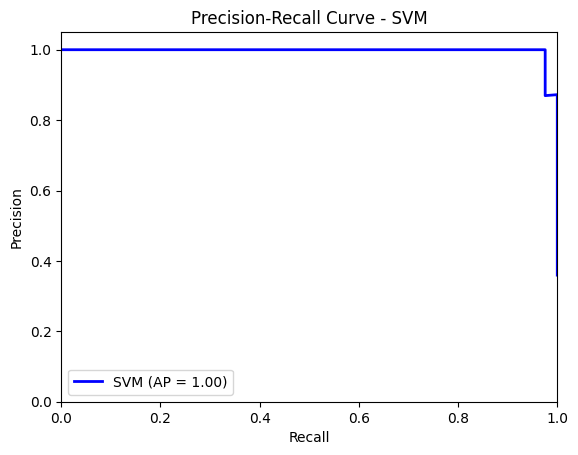

In [60]:
# Precision-Recall Curve for SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_proba_svm_tuned)
avg_precision_svm = average_precision_score(y_test, y_proba_svm_tuned)
plt.figure()
plt.plot(recall_svm, precision_svm, color='blue', lw=2, label=f'SVM (AP = {avg_precision_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve - SVM')
plt.legend(loc="lower left")
plt.show()

PermutationExplainer explainer: 115it [01:04,  1.52it/s]


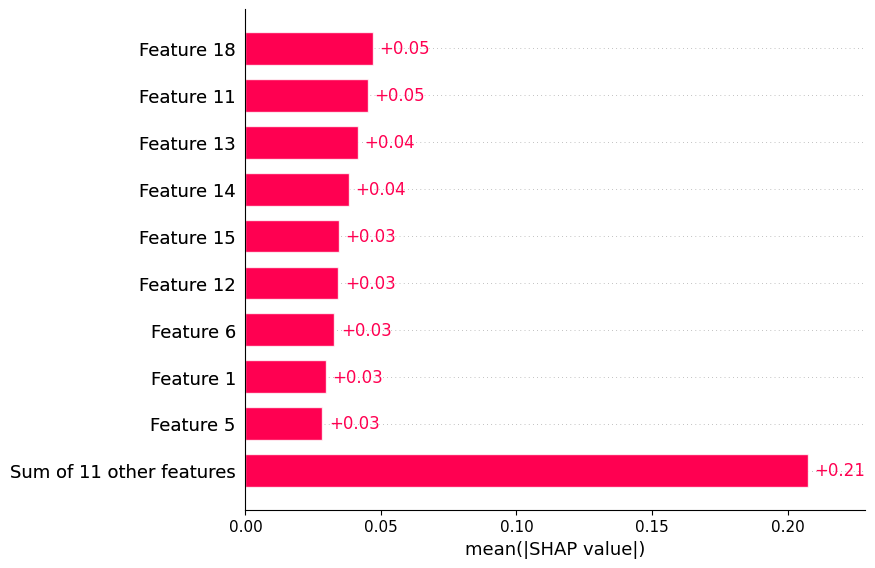

In [61]:
explainer_log = shap.Explainer(best_svm_model.predict, X_test_std)
shap_values_log = explainer_log(X_test_std)
shap.plots.bar(shap_values_log)